In [3]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Data loading, the full dataset from Retailrocket has been added to the dataset folder on the main root of the project's codebase.
# BASE_DIR = Path.cwd().parent
BASE_DIR = '..'


In [5]:
df_events = pd.read_csv(f'{BASE_DIR}/dataset/events.csv')
df_categories = pd.read_csv(f'{BASE_DIR}/dataset/category_tree.csv')
df_properties = pd.concat([pd.read_csv(f'{BASE_DIR}/dataset/item_properties_part1.csv'), pd.read_csv(f'{BASE_DIR}/dataset/item_properties_part2.csv')])

In [20]:
# The missing data in each table. It's important to identify these gaps early on.

def missing_values_summary(df, df_name):
    """Calculates and prints the missing values count and percentage for a DataFrame."""
    print(f"# Missing Values in {df_name}")
    missing_count = df.isnull().sum()
    missing_percentage = (missing_count / len(df)) * 100
    missing_df = pd.DataFrame({'Count': missing_count, 'Percentage': missing_percentage})
    print(missing_df[missing_df['Count'] > 0])
    print("\n")

missing_values_summary(df_events, 'df_events')
missing_values_summary(df_properties, 'df_properties')
missing_values_summary(df_categories, 'df_categories')

# Calculate and print unique counts from the events data
unique_visitors = df_events['visitorid'].nunique()
unique_items = df_events['itemid'].nunique()
unique_transactions = df_events['transactionid'].nunique()

print("# Unique Counts in df_events")
print(f"Number of unique visitors: {unique_visitors:,}")
print(f"Number of unique items involved in events: {unique_items:,}")
print(f"Number of unique transactions: {unique_transactions:,}")

# Missing Values in df_events
                 Count  Percentage
transactionid  2733644    99.18519


# Missing Values in df_properties
Empty DataFrame
Columns: [Count, Percentage]
Index: []


# Missing Values in df_categories
          Count  Percentage
parentid     25    1.497903


# Unique Counts in df_events
Number of unique visitors: 1,407,580
Number of unique items involved in events: 235,061
Number of unique transactions: 17,672


### Handling missing values

Our primary goal in this preprocessing step is not to simply drop missing data, but to understand why it's missing and handle it intelligently to preserve our valuable behavioral data.

In [21]:
print("Starting missing value handling...")

# 1. Handling df_events
# EDA showed 99.18% of 'transactionid' are NaN.
# This is expected. The 'transactionid' field is ONLY populated for the 'transaction' event type.
# The 99% of missing values represent all the 'view' and 'addtocart' events.
#
# We MUST NOT drop these rows. Dropping them would remove all our behavioral data
# for non-buying sessions, making it impossible to perform our behavioral clustering.
#
# Action:
# We will fill the NaN values with 0. This makes the column a clean integer type,
# which is easier for processing, and clearly separates non-transaction events (0) from
# actual transaction events (which have a positive ID).
original_event_count = len(df_events)
df_events['transactionid'] = df_events['transactionid'].fillna(0).astype(int)
print(f"Processed 'df_events'. 'transactionid' NaNs filled with 0.")
print(f"Row count remains {len(df_events)} (no rows dropped).")

# 2. Handling df_properties
# EDA showed 0 missing values.
# The data is clean.
# No action required.
print("\nProcessed 'df_properties'. No missing values found.")

# 3. Handling df_categories
# EDA showed 25 missing values for 'parentid'.
# This is also expected. These 25 rows are the "root" categories
# (e.g., "Electronics"). They do not have a parent, so the field is correctly left blank.
#
# We MUST NOT drop these rows, as that would break our category hierarchy.
#
# We will fill these NaNs with 0 to signify
# they are the top-level root nodes. This maintains the integrity of the tree structure.
original_category_count = len(df_categories)
df_categories['parentid'] = df_categories['parentid'].fillna(0).astype(int)
print(f"\nProcessed 'df_categories'. 'parentid' NaNs filled with 0 to represent root categories.")
print(f"Row count remains {len(df_categories)} (no rows dropped).")

print("\nMissing value handling complete.")

Starting missing value handling...
Processed 'df_events'. 'transactionid' NaNs filled with 0.
Row count remains 2756101 (no rows dropped).

Processed 'df_properties'. No missing values found.

Processed 'df_categories'. 'parentid' NaNs filled with 0 to represent root categories.
Row count remains 1669 (no rows dropped).

Missing value handling complete.


### Noise Handling

1. Statistical Noise (Outliers): We saw sessions with 7,000+ events and 50% of visitors with only 1 event. These extremes can pull the cluster centers.

2. Methodological Noise (Irrelevant Data): Sessions without a 'transaction' are essential data for clustering.

**Our Strategy**: We must remove these statistical outliers before we do anything else (like sessionization) because they will severely skew the feature calculations for our K-Means clustering.

In [22]:
# Step 1: Noise Handling (Statistical Outliers)

print(f"Original df_events shape: {df_events.shape}")

# 1. Identify Outlier Visitors
print("Calculating events per visitor...")
events_per_visitor = df_events.groupby('visitorid')['event'].count()

# The EDA showed a massive skew. We'll define 'noise' as the extreme outliers.
# We can find this threshold programmatically by using a
# high quantile. Let's use the 99.9th percentile as our cutoff.
outlier_threshold = events_per_visitor.quantile(0.999)
print(f"Outlier threshold (99.9th percentile) = {outlier_threshold} events")

# Get the list of visitorids that are above this threshold
outlier_visitors = events_per_visitor[events_per_visitor > outlier_threshold].index
print(f"Found {len(outlier_visitors)} outlier visitors.")


# 2. Filter Outlier Events

# Now, we remove all events associated with these outlier
# visitors from our main df_events dataframe. This ensures they
# won't impact our sessionization or feature engineering.
df_events_cleaned = df_events[~df_events['visitorid'].isin(outlier_visitors)].copy()


# 3. Report Results
original_events = len(df_events)
cleaned_events = len(df_events_cleaned)
events_removed = original_events - cleaned_events
percent_removed = (events_removed / original_events) * 100

print("\n# Noise Handling Summary")
print(f"Original total events: {original_events:,}")
print(f"Cleaned total events: {cleaned_events:,}")
print(f"Removed {events_removed:,} events ({percent_removed:.2f}%) belonging to {len(outlier_visitors)} visitors.")
print(f"Cleaned df_events_cleaned shape: {df_events_cleaned.shape}")

# REASONING: This cleaned dataframe is what we'll use for the next step.
# We'll re-assign df_events to this cleaned version for the rest of the pipeline.
df_events = df_events_cleaned

Original df_events shape: (2756101, 5)
Calculating events per visitor...
Outlier threshold (99.9th percentile) = 47.0 events
Found 1352 outlier visitors.

# Noise Handling Summary
Original total events: 2,756,101
Cleaned total events: 2,536,174
Removed 219,927 events (7.98%) belonging to 1352 visitors.
Cleaned df_events_cleaned shape: (2536174, 5)


### Summary

I chose Removal/Filtering because the data identified as "noise" was not just "extreme" data; it was anomalous data.

- Based on the EDAs, the median visitor had only 1 event, while the top 0.1% had over 32, with a max of 7,757.

Why I removed them instead of using other methods:

- They Aren't "Extreme Users," They're "Non-Users." A visitor with thousands of events is almost certainly a bot, scraper, or internal test account. This isn't just an "enthusiastic shopper"; it's a different category of user entirely. Our goal is to cluster real customer behavior, so these non-human actors must be removed.

Why Other Methods Don't Fit:

- Winsorizing (Capping): This technique is for limiting the influence of a single feature (e.g., capping a session duration at 3 hours). It doesn't make sense for a user. We can't "cap" a bot's behavior to make it look like a human—its entire pattern is wrong.

- Imputation/Replacement: These methods are for missing data, not bad data. We have no value to "impute" here.

- Data Smoothing: This is typically for time-series data to reduce signal jitter, which doesn't apply to our task of identifying outlier visitors.

In short: These visitors are removed because they are not part of the population we want to analyze. Their behavior is statistical "noise" that would contaminate our clusters, pulling the cluster centers away from the real, typical user groups we are trying to find.

## Making visitor sessions

In [23]:

print(f"Starting sessionization on {len(df_events):,} events...")

# 1. Convert Timestamp
# To calculate time differences, we must ensure the 'timestamp'
# column is in datetime format.
if not pd.api.types.is_datetime64_any_dtype(df_events['timestamp']):
    print("Converting timestamp from int (milliseconds) to datetime...")
    df_events['timestamp_dt'] = pd.to_datetime(df_events['timestamp'], unit='ms')
else:
    # Handle case where it might have been converted in a notebook
    df_events['timestamp_dt'] = pd.to_datetime(df_events['timestamp'])


# 2. Sort Values
# Sorting by visitor and time is CRITICAL. This ensures
# that events for the same user are sequential before we calculate
# the time difference between their actions.
print("Sorting events by visitorid and timestamp...")
df_events.sort_values(by=['visitorid', 'timestamp_dt'], inplace=True)


# 3. Calculate Time Difference
# We define a session as a period of activity ending with
# 30 minutes (1800 seconds) of inactivity.
session_timeout_seconds = 30 * 60

# We use groupby('visitorid').diff() to calculate the time (in seconds)
# between consecutive events *for the same visitor*.
# The first event for any visitor will result in 'NaT' (Not a Time).
print("Calculating time difference between events for each visitor...")
df_events['time_diff_seconds'] = df_events.groupby('visitorid')['timestamp_dt'].diff().dt.total_seconds()


# 4. Identify New Sessions
# A new session starts when the time_diff is > our timeout,
# OR when it's the very first event for that user (where time_diff is NaN/NaT).
# We create a boolean flag 'new_session_flag' for this.
df_events['new_session_flag'] = (df_events['time_diff_seconds'] > session_timeout_seconds) | (df_events['time_diff_seconds'].isnull())


# 5. Assign Session IDs
# We use cumsum() (cumulative sum) on the 'new_session_flag'
# boolean (where True=1, False=0). This creates a unique, incrementing ID
# for each new session within that visitor's group.
print("Assigning unique session IDs...")
df_events['session_increment_id'] = df_events.groupby('visitorid')['new_session_flag'].cumsum()

# Create a globally unique session_id by combining the visitorid
# (as a string) with the session_increment_id. This will be our
# primary key for the new session-feature matrix.
df_events['session_id'] = df_events['visitorid'].astype(str) + '_' + df_events['session_increment_id'].astype(str)


# 6. Report Results
session_count = df_events['session_id'].nunique()
visitor_count = df_events['visitorid'].nunique()
avg_sessions_per_visitor = session_count / visitor_count
avg_events_per_session = len(df_events) / session_count

print("\n--- Sessionization Summary ---")
print(f"Total events processed: {len(df_events):,}")
print(f"Total unique visitors: {visitor_count:,}")
print(f"Total unique sessions created: {session_count:,}")
print(f"Average sessions per visitor: {avg_sessions_per_visitor:.2f}")
print(f"Average events per session: {avg_events_per_session:.2f}")

# Display a sample of the sessionized data to verify
print("\nSample of sessionized data (showing new session flags):")
display(df_events[['timestamp_dt', 'visitorid', 'event', 'time_diff_seconds', 'new_session_flag', 'session_id']].head(10))

# Clean up intermediate columns before next step
df_events.drop(columns=['time_diff_seconds', 'new_session_flag', 'session_increment_id'], inplace=True)


Starting sessionization on 2,536,174 events...
Converting timestamp from int (milliseconds) to datetime...
Sorting events by visitorid and timestamp...
Calculating time difference between events for each visitor...
Assigning unique session IDs...

--- Sessionization Summary ---
Total events processed: 2,536,174
Total unique visitors: 1,406,228
Total unique sessions created: 1,722,864
Average sessions per visitor: 1.23
Average events per session: 1.47

Sample of sessionized data (showing new session flags):


,timestamp_dt,visitorid,event,time_diff_seconds,new_session_flag,session_id
1361687,2015-09-11 20:49:49.439,0,view,NaN,True,0_1
1367212,2015-09-11 20:52:39.591,0,view,170.152,False,0_1
1367342,2015-09-11 20:55:17.175,0,view,157.584,False,0_1
830385,2015-08-13 17:46:06.444,1,view,NaN,True,1_1
742616,2015-08-07 17:51:44.567,2,view,NaN,True,2_1
735273,2015-08-07 17:53:33.790,2,view,109.223,False,2_1
737711,2015-08-07 17:56:52.664,2,view,198.874,False,2_1
726292,2015-08-07 18:01:08.920,2,view,256.256,False,2_1
737615,2015-08-07 18:08:25.669,2,view,436.749,False,2_1
735202,2015-08-07 18:17:24.375,2,view,538.706,False,2_1


### Feature Engineering for Clustering



In [24]:
print("Starting lookup map creation...")

# --- 1. Item-to-Category Map ---
# REASONING: We need a simple map of [itemid -> categoryid] to enrich both our
# session features and our market baskets.
print("Creating Item-to-Category map...")
item_category_map = df_properties[df_properties['property'] == 'categoryid'].copy()

# The properties file can have multiple categories for the same item over time.
# For simplicity, we'll take the *most recent* category entry for each item.
item_category_map.sort_values(by=['itemid', 'timestamp'], ascending=[True, False], inplace=True)
item_category_map = item_category_map.drop_duplicates(subset='itemid', keep='first')

# Convert value to int for clean merging
item_category_map['categoryid'] = item_category_map['value'].astype(int)
item_category_map = item_category_map[['itemid', 'categoryid']]

print(f"Created item_category_map with {len(item_category_map):,} unique item-category pairs.")


# --- 2. Item Availability Map ---
# REASONING: This map will tell us if an item was in stock at the time
# of an event. This is tricky because availability changes over time.
print("Creating Item Availability map...")
item_availability_map = df_properties[df_properties['property'] == 'available'].copy()

# Convert value to int (0 or 1) and timestamp to datetime for merging
item_availability_map['is_available'] = item_availability_map['value'].astype(int)
item_availability_map['timestamp_dt'] = pd.to_datetime(item_availability_map['timestamp'], unit='ms')

# Keep only the columns needed for the `merge_asof`
item_availability_map = item_availability_map[['itemid', 'timestamp_dt', 'is_available']]

# Sort by the keys we will merge on
item_availability_map.sort_values(by=['itemid', 'timestamp_dt'], inplace=True)
print(f"Created item_availability_map with {len(item_availability_map):,} availability records.")


# (Optional but good for validation) Category Name Map ---
# REASONING: This isn't required for the model, but helps in profiling
# our clusters later (e.g., seeing Cluster 3 is "Electronics").
# The 'category_tree.csv' has parent IDs. We'll assume the 'categoryid'
# itself is the most descriptive name for now.
category_name_map = df_categories[['categoryid']].copy()
# We could try to join parent names later if needed.
print(f"Created category_name_map with {len(category_name_map):,} categories.")

print("\nLookup map creation complete.")
print("The key dataframes for the next step are: 'item_category_map' and 'item_availability_map'.")

Starting lookup map creation...
Creating Item-to-Category map...
Created item_category_map with 417,053 unique item-category pairs.
Creating Item Availability map...
Created item_availability_map with 1,503,639 availability records.
Created category_name_map with 1,669 categories.

Lookup map creation complete.
The key dataframes for the next step are: 'item_category_map' and 'item_availability_map'.


In [25]:
print("Starting rich feature engineering...")
print(f"Original df_events shape: {df_events.shape}")

# --- 1. Enrich Events ---
# REASONING: We add time-based features (day/hour) from the timestamp.
# These will be aggregated to find time-of-day or day-of-week patterns.
print("Extracting time-based features (hour, day)...")
df_events['session_hour_of_day'] = df_events['timestamp_dt'].dt.hour
df_events['session_day_of_week'] = df_events['timestamp_dt'].dt.dayofweek

# REASONING: We do a left merge to add 'categoryid' to every event.
# Events for items not in the properties file will have NaN.
print("Enriching events with 'categoryid'...")
df_events_rich = pd.merge(df_events, item_category_map, on='itemid', how='left')

# REASONING: This is the time-sensitive merge. We use pd.merge_asof()
# to join each event with the *last known availability* status *before*
# that event occurred.
# We must sort both dataframes by the merge keys ('itemid', 'timestamp_dt').
print("Enriching events with 'is_available' (using merge_asof)...")
df_events_rich = pd.merge_asof(
    df_events_rich.sort_values('timestamp_dt'),
    item_availability_map.sort_values('timestamp_dt'),
    on='timestamp_dt',
    by='itemid',
    direction='backward' # Finds the last known value before the event
)

# REASONING: After the merge, 'is_available' will be NaN for items with no
# availability data. We'll assume these items are unavailable (0).
df_events_rich['is_available'] = df_events_rich['is_available'].fillna(0).astype(int)


# --- 2. Aggregate Session-Level Features ---
# REASONING: Now we group by 'session_id' and aggregate all event-level
# data into a single row per session.
print("Aggregating features by session_id...")
agg_dict = {
    'timestamp_dt': [lambda x: (x.max() - x.min()).total_seconds(), 'min'], # Duration and start time
    'event': 'count',                 # total_events
    'itemid': 'nunique',              # unique_items_viewed
    'categoryid': 'nunique',          # unique_categories_viewed
    'is_available': 'mean',           # avg_item_availability
    'session_hour_of_day': 'first',   # Time of session start
    'session_day_of_week': 'first'    # Day of session start
}

session_features = df_events_rich.groupby('session_id').agg(agg_dict)

# REASONING: Flatten the multi-index columns created by .agg()
session_features.columns = ['session_duration_sec', 'session_start_time',
                            'total_events', 'unique_items_viewed',
                            'unique_categories_viewed', 'avg_item_availability',
                            'session_hour_of_day', 'session_day_of_week']


# --- 3. Pivot Event Counts ---
# REASONING: We need specific counts for 'view', 'addtocart', and 'transaction'
# to build our ratio features and identify buyers.
print("Pivoting event counts...")
event_counts = df_events_rich.groupby('session_id')['event'].value_counts().unstack(fill_value=0)

# REASONING: Rename columns for clarity.
event_counts.columns = [col + '_count' for col in event_counts.columns]

# Ensure all three columns exist, even if one event type (like 'transaction')
# didn't happen in any session (unlikely, but safe)
for col in ['view_count', 'addtocart_count', 'transaction_count']:
    if col not in event_counts.columns:
        event_counts[col] = 0

# REASONING: Create our key target variable, 'is_buyer'.
event_counts['is_buyer'] = (event_counts['transaction_count'] > 0).astype(int)


# --- 4. Combine and Create Final Ratio Features ---
# REASONING: Merge our two aggregated dataframes to create the final matrix.
print("Combining aggregated dataframes...")
session_feature_matrix = pd.merge(session_features, event_counts, on='session_id', how='left')

# REASONING: Create the final ratio features based on our plan.
# We handle division by zero (e.g., sessions with 0 duration or 0 views)
# by replacing resulting 'inf' or 'NaN' values with 0.
print("Creating final ratio features...")

# Event rate (how fast the user is clicking)
session_feature_matrix['event_rate_per_sec'] = (
    session_feature_matrix['total_events'] / (session_feature_matrix['session_duration_sec'] + 1) # +1 to avoid 0s
).fillna(0)

# View-to-cart ratio (micro-conversion)
session_feature_matrix['view_to_cart_ratio'] = (
    session_feature_matrix['addtocart_count'] / session_feature_matrix['view_count']
).fillna(0).replace(np.inf, 0)

# Category spread (focused vs. broad browser)
session_feature_matrix['category_spread_ratio'] = (
    session_feature_matrix['unique_categories_viewed'] / session_feature_matrix['unique_items_viewed']
).fillna(0).replace(np.inf, 0)

# Is weekend
session_feature_matrix['is_weekend'] = (
    session_feature_matrix['session_day_of_week'].isin([5, 6])
).astype(int)

# --- 5. Report Results ---
print("\n--- Feature Engineering Summary ---")
print(f"Final session_feature_matrix shape: {session_feature_matrix.shape}")
print("\nFinal Matrix Info:")
session_feature_matrix.info()
print("\nSample of final feature matrix (first 5 rows):")
print(session_feature_matrix.head())


Starting rich feature engineering...
Original df_events shape: (2536174, 7)
Extracting time-based features (hour, day)...
Enriching events with 'categoryid'...
Enriching events with 'is_available' (using merge_asof)...
Aggregating features by session_id...
Pivoting event counts...
Combining aggregated dataframes...
Creating final ratio features...

--- Feature Engineering Summary ---
Final session_feature_matrix shape: (1722864, 16)

Final Matrix Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1722864 entries, 0_1 to 9_1
Data columns (total 16 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   session_duration_sec      float64       
 1   session_start_time        datetime64[ns]
 2   total_events              int64         
 3   unique_items_viewed       int64         
 4   unique_categories_viewed  int64         
 5   avg_item_availability     float64       
 6   session_hour_of_day       int32         
 7   session_day_of_wee

In [26]:
# Features

display(session_feature_matrix.head())

session_feature_matrix.to_csv(f'{BASE_DIR}/session_feature_matrix.csv')
print(f"Features session matrix data saved to '{BASE_DIR}/session_feature_matrix.csv'.")

,session_duration_sec,session_start_time,total_events,unique_items_viewed,unique_categories_viewed,avg_item_availability,session_hour_of_day,session_day_of_week,addtocart_count,transaction_count,view_count,is_buyer,event_rate_per_sec,view_to_cart_ratio,category_spread_ratio,is_weekend
session_id,,,,,,,,,,,,,,,,
0_1,327.736,2015-09-11 20:49:49.439,3,3,3,0.333333,20,4,0,0,3,0,0.009126,0.0,1.000000,0
1000000_1,0.000,2015-06-05 18:16:10.629,1,1,1,0.000000,18,4,0,0,1,0,1.000000,0.0,1.000000,0
1000001_1,0.000,2015-07-07 18:12:14.953,1,1,1,0.000000,18,1,0,0,1,0,1.000000,0.0,1.000000,0
1000001_2,1061.726,2015-07-24 20:18:15.303,3,3,2,1.000000,20,4,0,0,3,0,0.002823,0.0,0.666667,0
1000001_3,0.000,2015-07-29 20:38:29.170,1,1,1,1.000000,20,2,0,0,1,0,1.000000,0.0,1.000000,0


Features session matrix data saved to '/content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project/session_feature_matrix.csv'.


In [ ]:
# --- Load Data ---
# Assuming 'df_events_rich' (from your last step) and 'item_category_map'
# are in memory.

print("Starting Market Basket Creation...")

# --- 1. Filter for Transaction Events ---
# REASONING: We only care about actual purchases for market baskets.
# We filter the main 'df_events' dataframe for 'transaction' events.
# We also filter out transactionid == 0, which was our fillna() value
# for non-transaction events.
transactions_only = df_events[
    (df_events['event'] == 'transaction') & (df_events['transactionid'] != 0)
].copy()

print(f"Filtered down to {len(transactions_only):,} transaction events.")


# --- 2. Item Baskets ---
# REASONING: Create a list of itemids for each unique transaction.
print("Creating item-level baskets...")
item_baskets_df = transactions_only.groupby('transactionid')['itemid'].apply(list)
item_baskets = item_baskets_df.tolist()

print(f"Created {len(item_baskets):,} item-level market baskets.")
if item_baskets:
    print("Sample item basket:", item_baskets[0])
else:
    print("No item baskets were created.")


# --- 3. Category Baskets ---
# REASONING: Now we create a new, separate dataframe by merging our
# 'transactions_only' events with the 'item_category_map'
# This 'transactions_with_category' dataframe will now have
# 'transactionid', 'itemid', AND 'categoryid'.
print("\nCreating category-level baskets...")
transactions_with_category = pd.merge(
    transactions_only,
    item_category_map,
    on='itemid',
    how='left'
)

# Handle items that might not have had a category
transactions_with_category['categoryid'] = transactions_with_category['categoryid'].fillna(0).astype(int)

# REASONING: Now we can successfully group by 'transactionid' and
# get the list of 'categoryid's.
category_baskets_df = transactions_with_category.groupby('transactionid')['categoryid'].apply(list)
category_baskets = category_baskets_df.tolist()

print(f"Created {len(category_baskets):,} category-level market baskets.")
if category_baskets:
    print("Sample category basket:", category_baskets[0])
else:
    print("No category baskets were created.")


# --- 4. Save Baskets for Milestone 2 ---
# REASONING: We'll save these to disk so they are ready for the Apriori
# algorithm in Week 3. We'll save them as text files, one basket per line.

def save_baskets_to_file(baskets, filename):
    print(f"Saving {len(baskets)} baskets to {filename}...")
    try:
        with open(filename, 'w') as f:
            for basket in baskets:
                # Convert items (which are ints) to strings for joining
                f.write(','.join(map(str, basket)) + '\n')
        print(f"Save complete to {filename}.")
    except Exception as e:
        print(f"Error saving file {filename}: {e}")

save_baskets_to_file(item_baskets, f'{BASE_DIR}/item_baskets.csv')
save_baskets_to_file(category_baskets, f'{BASE_DIR}/category_baskets.csv')

print("\nMarket Basket creation complete.")

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# --- Load Data ---
# Assuming 'session_feature_matrix' is in memory from Step 4.

print("Starting data scaling for K-Means...")

# --- 1. Select Features for Clustering ---
# REASONING: We will select only the numerical features that describe
# session *behavior*. We exclude non-behavioral columns like
# 'session_start_time' and 'is_buyer' (which we'll use later for profiling,
# not for the clustering itself).
features_for_clustering = [
    'session_duration_sec',
    'total_events',
    'unique_items_viewed',
    'unique_categories_viewed',
    'avg_item_availability',
    'session_hour_of_day',
    'view_count',
    'addtocart_count',
    'event_rate_per_sec',
    'view_to_cart_ratio',
    'category_spread_ratio',
    'is_weekend'
]

# Create the final matrix for clustering
X = session_feature_matrix[features_for_clustering]

# REASONING: Handle any potential inf/-inf values that might have resulted
# from division, just in case.
X.replace([np.inf, -np.inf], 0, inplace=True)


# --- 2. Scale the Data ---
# REASONING: We use StandardScaler to transform the data so that each
# feature has a mean of 0 and a standard deviation of 1. This
# standardizes their importance for the K-Means algorithm.
print("Scaling features using StandardScaler...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to a DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)


# --- 3. Report Results ---
print("\n--- Scaling Summary ---")
print(f"Data scaled successfully. Shape: {X_scaled_df.shape}")
print("\nSample of scaled data:")
print(X_scaled_df.head())

print("\n--- MILESTONE 1 (PREPROCESSING) COMPLETE ---")
print("You are now ready for Milestone 2: K-Means Clustering.")

# Save the scaled data for the next notebook
X_scaled_df.to_csv(f'{BASE_DIR}/session_feature_matrix_scaled.csv')
print(f"Scaled data saved to '{BASE_DIR}/session_feature_matrix_scaled.csv'.")

Starting data scaling for K-Means...


/tmp/ipython-input-2304352175.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], 0, inplace=True)


Scaling features using StandardScaler...

--- Scaling Summary ---
Data scaled successfully. Shape: (1722864, 12)

Sample of scaled data:
            session_duration_sec  total_events  unique_items_viewed  \
session_id                                                            
0_1                     0.747928      1.016926             1.725313   
1000000_1              -0.269207     -0.314189            -0.269693   
1000001_1              -0.269207     -0.314189            -0.269693   
1000001_2               3.025881      1.016926             1.725313   
1000001_3              -0.269207     -0.314189            -0.269693   

            unique_categories_viewed  avg_item_availability  \
session_id                                                    
0_1                         4.372708              -0.127893   
1000000_1                   0.147813              -0.827871   
1000001_1                   0.147813              -0.827871   
1000001_2                   2.260261              

In [ ]:
# 1. Session Duration Distribution
sns.histplot(session_feature_matrix['session_duration_sec'], bins=50, kde=True)
plt.title("Distribution of Session Duration (sec)")
plt.xlabel("Session Duration (sec)"); plt.ylabel("Frequency")
plt.show()

# 2. Session Start Time Heatmap
pd.crosstab(session_feature_matrix['session_day_of_week'], session_feature_matrix['session_hour_of_day']) \
  .pipe(lambda df: sns.heatmap(df, cmap="YlGnBu"))
plt.title("Sessions by Hour and Day of Week")
plt.show()

# 3. Buyer vs. Non-Buyer Boxplot
sns.boxplot(x="is_buyer", y="view_to_cart_ratio", data=session_feature_matrix)
plt.title("View-to-Cart Ratio: Buyer vs. Non-Buyer")
plt.show()

# 4. Correlation Heatmap
corr = session_feature_matrix.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


## K-Means Clustering

This is the same kmeans we ran initially that gave us 5 clusters.

Challenges/Issues found with this:
*   We used a sample size of 20K (while we have 1.7 million sessions) - largely under-represents our data
*   Expensive: the clustering, especially with Silhoutte scores added took way too long.

Alternatives:
- Use MiniBatchKMeans: we can use all our sessions
- Compute Siloutte scores only for a 100K sample, support this using the elbow curve method comparison




Running MiniBatchKMeans for k=2 to 10...
  → Fitting k=2
     Inertia: 17316361.94, Silhouette: 0.3762
  → Fitting k=3
     Inertia: 16669930.22, Silhouette: 0.2199
  → Fitting k=4
     Inertia: 13814191.21, Silhouette: 0.3618
  → Fitting k=5
     Inertia: 11628794.75, Silhouette: 0.3243
  → Fitting k=6
     Inertia: 11314228.06, Silhouette: 0.3492
  → Fitting k=7
     Inertia: 9116460.94, Silhouette: 0.4383
  → Fitting k=8
     Inertia: 8369696.04, Silhouette: 0.3834
  → Fitting k=9
     Inertia: 7363436.60, Silhouette: 0.4272
  → Fitting k=10
     Inertia: 6996197.13, Silhouette: 0.4327


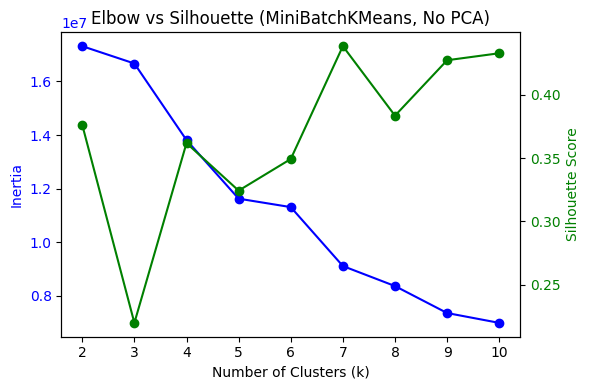

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# Optional: Intel acceleration (massive speed-up on CPU)
# from sklearnex import patch_sklearn
# patch_sklearn()

# Downsample for silhouette (since silhouette is O(n²))
sample_idx = np.random.choice(len(X_scaled_df), size=100000, replace=False)
X_sample = X_scaled_df.iloc[sample_idx]

inertias, silhouettes = [], []
k_range = range(2, 11)

print("\nRunning MiniBatchKMeans for k=2 to 10...")

for k in k_range:
    print(f"  → Fitting k={k}")
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        batch_size=10000,   # tweak between 5k–50k based on RAM
        n_init="auto",
        random_state=42
    )
    kmeans.fit(X_scaled_df)
    inertias.append(kmeans.inertia_)

    # Predict labels for the sampled subset
    labels_sample = kmeans.predict(X_sample)
    silhouette = silhouette_score(X_sample, labels_sample)
    silhouettes.append(silhouette)

    print(f"     Inertia: {kmeans.inertia_:.2f}, Silhouette: {silhouette:.4f}")

# Plot results
fig, ax1 = plt.subplots(figsize=(6, 4))

ax1.plot(k_range, inertias, 'bo-', label='Inertia (Elbow)')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(k_range, silhouettes, 'go-', label='Silhouette')
ax2.set_ylabel('Silhouette Score', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('Elbow vs Silhouette (MiniBatchKMeans, No PCA)')
fig.tight_layout()
plt.show()

Starting with k=2
  True Inertia (WCSS) for k=2: 17316361.94
  Calculating silhouette score on 100000 samples...
  Silhouette Score for k=2: 0.3761
Starting with k=3
  True Inertia (WCSS) for k=3: 16669930.22
  Calculating silhouette score on 100000 samples...
  Silhouette Score for k=3: 0.2190
Starting with k=4
  True Inertia (WCSS) for k=4: 13814191.21
  Calculating silhouette score on 100000 samples...
  Silhouette Score for k=4: 0.3598
Starting with k=5
  True Inertia (WCSS) for k=5: 11628794.75
  Calculating silhouette score on 100000 samples...
  Silhouette Score for k=5: 0.3240
Starting with k=6
  True Inertia (WCSS) for k=6: 11314228.06
  Calculating silhouette score on 100000 samples...
  Silhouette Score for k=6: 0.3458
Starting with k=7
  True Inertia (WCSS) for k=7: 9116460.94
  Calculating silhouette score on 100000 samples...
  Silhouette Score for k=7: 0.4371
Starting with k=8
  True Inertia (WCSS) for k=8: 8369696.04
  Calculating silhouette score on 100000 samples...
 

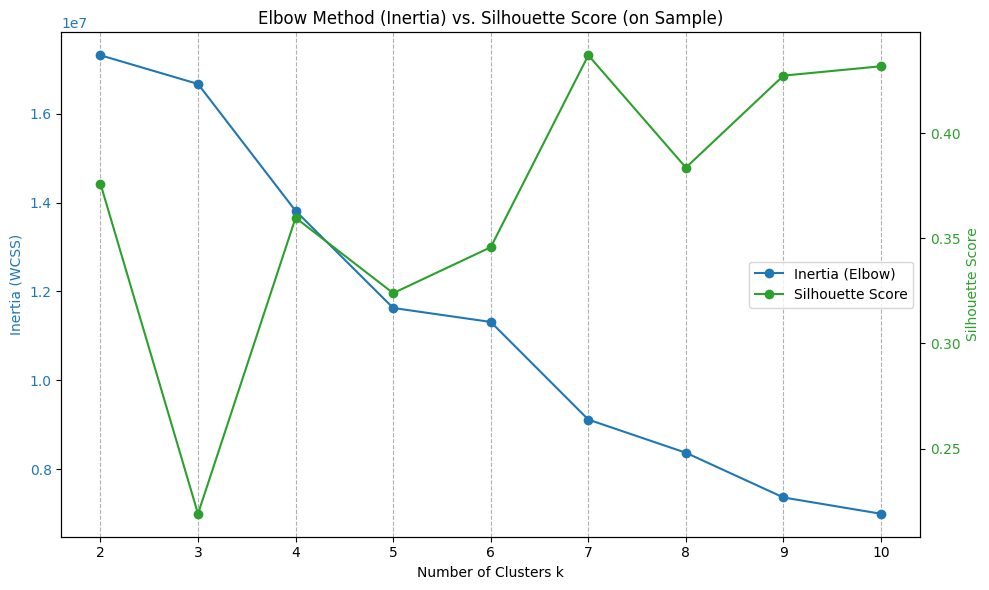

Done.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# --- Configuration ---
k_range = range(2, 11)
# We will calculate silhouette score on a random sample to make it feasible
# 50,000 is a good size, but you can lower to 10k or 20k for more speed.
SILHOUETTE_SAMPLE_SIZE = 100000

inertias = []
silhouette_scores = []

n_samples = X_scaled_df.shape[0]
if SILHOUETTE_SAMPLE_SIZE > n_samples:
    SILHOUETTE_SAMPLE_SIZE = n_samples

for k in k_range:
    print(f'Starting with k={k}')

    # --- Solution 1: Use MiniBatchKMeans ---
    kmeans = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        n_init="auto",
        batch_size=10000 # Default is 1024, adjust based on your memory
    )

    kmeans.fit(X_scaled_df)
    distances = kmeans.transform(X_scaled_df)
    min_distances = np.min(distances, axis=1)
    true_inertia = np.sum(min_distances**2)
    inertias.append(true_inertia)
    print(f"  True Inertia (WCSS) for k={k}: {true_inertia:.2f}")

    print(f"  Calculating silhouette score on {SILHOUETTE_SAMPLE_SIZE} samples...")
    all_labels = kmeans.labels_
    # Create a random sample
    sample_indices = np.random.choice(n_samples, SILHOUETTE_SAMPLE_SIZE, replace=False)

    if isinstance(X_scaled_df, pd.DataFrame):
        X_sample = X_scaled_df.iloc[sample_indices]
    else:
        X_sample = X_scaled_df[sample_indices]

    labels_sample = all_labels[sample_indices]

    sil_score = silhouette_score(X_sample, labels_sample)
    silhouette_scores.append(sil_score)
    print(f"  Silhouette Score for k={k}: {sil_score:.4f}")

# --- Plotting (largely unchanged, just variable name updated) ---
print("\nPlotting results...")
fig, ax1 = plt.subplots(figsize=(10, 6)) # Made plot a bit wider

# Primary y-axis: Inertia (Elbow Method)
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters k')
ax1.set_ylabel('Inertia (WCSS)', color=color)
ax1.plot(k_range, inertias, 'o-', color=color, label='Inertia (Elbow)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(axis='x', linestyle='--')

# Secondary y-axis: Silhouette Score
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_range, silhouette_scores, 'o-', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout
plt.title('Elbow Method (Inertia) vs. Silhouette Score (on Sample)')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.xticks(k_range)
# Adding legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')

plt.show()
print("Done.")

In [ ]:
k = 7
SILHOUETTE_SAMPLE_SIZE = 100000

n_samples = X_scaled_df.shape[0]
# Ensure sample size does not exceed data size
if SILHOUETTE_SAMPLE_SIZE > n_samples:
    SILHOUETTE_SAMPLE_SIZE = n_samples

print(f'Starting clustering with k={k}')

# Fit MiniBatchKMeans with k=7
kmeans = MiniBatchKMeans(
    n_clusters=k,
    random_state=42,
    n_init="auto",
    batch_size=10000
)

kmeans.fit(X_scaled_df)
distances = kmeans.transform(X_scaled_df)
min_distances = np.min(distances, axis=1)
true_inertia = np.sum(min_distances**2)
print(f"True Inertia (WCSS) for k={k}: {true_inertia:.2f}")

print(f"Calculating silhouette score on {SILHOUETTE_SAMPLE_SIZE} samples...")
all_labels = kmeans.labels_
# Random sample indices
sample_indices = np.random.choice(n_samples, SILHOUETTE_SAMPLE_SIZE, replace=False)

if isinstance(X_scaled_df, pd.DataFrame):
    X_sample = X_scaled_df.iloc[sample_indices]
else:
    X_sample = X_scaled_df[sample_indices]

labels_sample = all_labels[sample_indices]
sil_score = silhouette_score(X_sample, labels_sample)
print(f"Silhouette Score for k={k}: {sil_score:.4f}")

print("Saving cluster labels")
cluster_labels = kmeans.labels_

X_scaled_df['cluster'] = cluster_labels

# Option 1: Save only the scaled features + cluster assignment
X_scaled_df.to_csv(f'{BASE_DIR}/session_feature_matrix_with_k7_clusters.csv', index=True)

# Option 2: Merge cluster assignments back to the original features for enhanced plotting
# (Assumes you have an unscaled features DataFrame called orig_features with matching index/session_id)
orig_features = pd.read_csv(f'{BASE_DIR}/session_feature_matrix.csv', index_col='session_id')
orig_features['cluster'] = cluster_labels
orig_features.to_csv(f'{BASE_DIR}/session_feature_matrix_with_k7_clusters.csv', index=True)

print("Done.")

Starting clustering with k=7
True Inertia (WCSS) for k=7: 9116460.94
Calculating silhouette score on 100000 samples...
Silhouette Score for k=7: 0.4360
Saving cluster labels
Done.


/tmp/ipython-input-1983884952.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


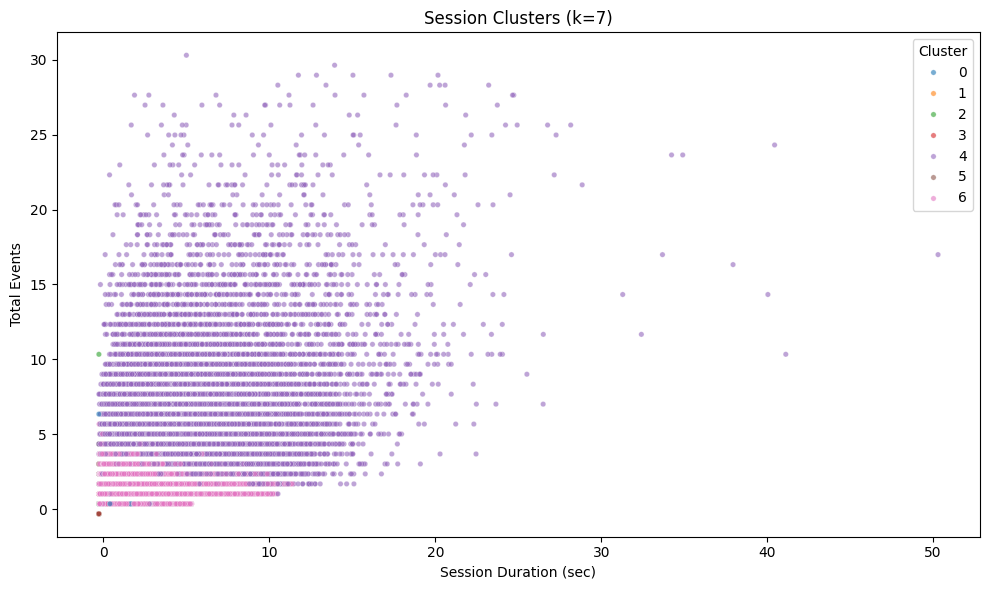

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


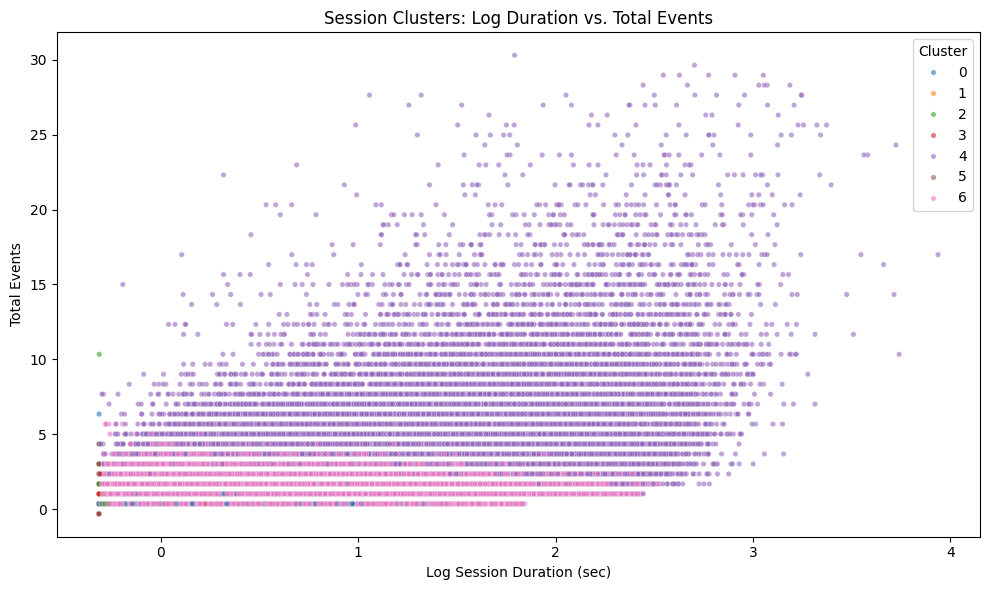

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


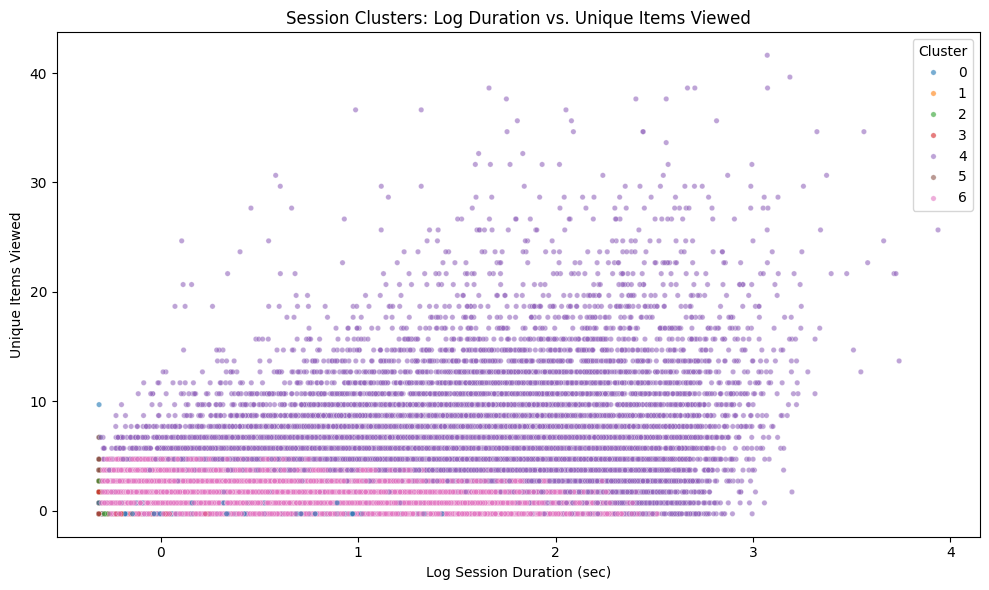

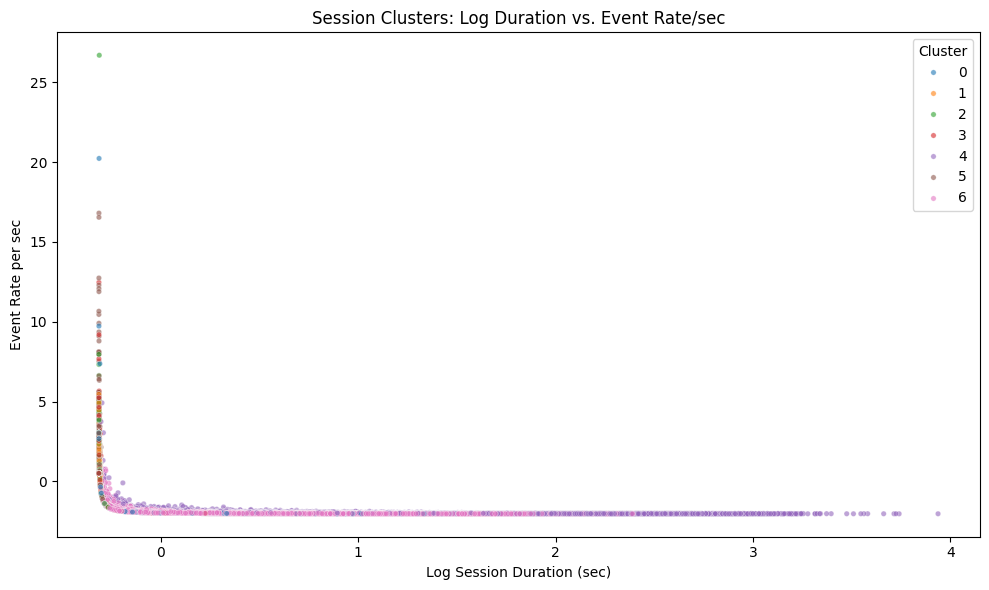

In [ ]:
df = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_with_k7_clusters.csv', index_col='session_id')

# OPTIONAL sample for speedier plotting
# df = df.sample(n=5000, random_state=42)

# 1. Session Duration vs. Total Events (linear)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='session_duration_sec',
    y='total_events',
    hue='cluster',
    palette='tab10',
    alpha=0.6,
    s=15
)
plt.title('Session Clusters (k=7)')
plt.xlabel('Session Duration (sec)')
plt.ylabel('Total Events')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 2. Log(Session Duration) vs. Total Events
df['log_session_duration'] = np.log(df['session_duration_sec'] + 1)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='log_session_duration',
    y='total_events',
    hue='cluster',
    palette='tab10',
    alpha=0.6,
    s=15
)
plt.title('Session Clusters: Log Duration vs. Total Events')
plt.xlabel('Log Session Duration (sec)')
plt.ylabel('Total Events')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 3. Log(Session Duration) vs. Unique Items Viewed
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='log_session_duration',
    y='unique_items_viewed',
    hue='cluster',
    palette='tab10',
    alpha=0.6,
    s=15
)
plt.title('Session Clusters: Log Duration vs. Unique Items Viewed')
plt.xlabel('Log Session Duration (sec)')
plt.ylabel('Unique Items Viewed')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

# 4. Log(Session Duration) vs. Event Rate per Second
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='log_session_duration',
    y='event_rate_per_sec',
    hue='cluster',
    palette='tab10',
    alpha=0.6,
    s=15
)
plt.title('Session Clusters: Log Duration vs. Event Rate/sec')
plt.xlabel('Log Session Duration (sec)')
plt.ylabel('Event Rate per sec')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
# 1. Load the Scaled Data
# We must use the scaled data from (1. K-Means)
# is distance-based, so this ensures all features are weighted equally.
try:
    X_scaled_df = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_scaled.csv', index_col='session_id')
    print(f"Loaded scaled feature matrix with shape: {X_scaled_df.shape}")
except FileNotFoundError:
    print("Error: 'session_feature_matrix_scaled.csv' not found.")
    print("Please ensure you have run the feature engineering notebook first.")
    # In a notebook, you might 'raise' this error to stop execution
    X_scaled_df = None # Set to None to prevent further execution in this block

# if X_scaled_df is not None:
#     # 2. Calculate WCSS (Inertia) for a Range of k
#     # REASONING: We will test a range of cluster counts (k) to find
#     # the one with the best inertia score.
#     wcss = []
#     inertias = []
#     k_range = range(1, 11) # Test k from 1 to 20

#     print("\nCalculating WCSS (inertia) for k=2 to 10...")

#     for k in k_range:
#         # We use 'k-means++' for smarter initial cluster center placement.
#         # 'n_init=10' runs the algorithm 10 times with different centroids
#         # and picks the best result, which helps avoid local optima.
#         kmeans = KMeans(n_clusters=k, random_state=42)
#         kmeans.fit(X_scaled_df)
#         inertias.append(kmeans.inertia_)
#         wcss.append(silhouette_score(X_scaled_df,kmeans.labels_))
#         print(f"  WCSS for k={k}: {kmeans.inertia_:.2f}")

wcss = []
inertias = []
k_range = range(2, 11) # Test k from 1 to 20

print("\nCalculating WCSS (inertia) for k=2 to 10...")

for k in k_range:
    print(f'Starting with k={k}')
    # We use 'k-means++' for smarter initial cluster center placement.
        # 'n_init=10' runs the algorithm 10 times with different centroids
        # and picks the best result, which helps avoid local optima.
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled_df)
    inertias.append(kmeans.inertia_)
    wcss.append(silhouette_score(X_scaled_df, kmeans.labels_))
    print(f"  WCSS for k={k}: {kmeans.inertia_:.2f}")

fig, ax1 = plt.subplots(figsize=(6, 4))

# Primary y-axis: Inertia (Elbow Method)
ax1.plot(k_range, inertias, 'bo-', label='Inertia (Elbow)')
ax1.set_xlabel('Number of Clusters k')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Secondary y-axis: Silhouette Score
ax2 = ax1.twinx()
ax2.plot(k_range, wcss, 'go-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Title and layout
plt.title('Elbow Method vs. Silhouette Score')
fig.tight_layout()
plt.show()
    # print("Calculation complete.")

    # # 3. Plot the Elbow Curve
    # # REASONING: We now plot the results. The "elbow" point, where the
    # # graph's slope changes from steep to shallow, is considered the
    # # optimal k.
    # print("Plotting the Elbow Curve...")
    # plt.figure(figsize=(10, 6))
    # plt.plot(k_range, wcss, marker='o', linestyle='--')
    # plt.title('The Elbow Method for Optimal k')
    # plt.xlabel('Number of Clusters (k)')
    # plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    # plt.xticks(k_range)
    # plt.grid(True)
    # plt.show()

Dataset shape: (1722864, 12)
Loaded scaled feature matrix with shape: (1722864, 12)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
# 1. Load the Scaled Data
# We must use the scaled data from (1. K-Means)
# is distance-based, so this ensures all features are weighted equally.
# try:
#     X_scaled_df = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_scaled.csv', index_col='session_id')
#     print(f"Loaded scaled feature matrix with shape: {X_scaled_df.shape}")
# except FileNotFoundError:
#     print("Error: 'session_feature_matrix_scaled.csv' not found.")
#     print("Please ensure you have run the feature engineering notebook first.")
#     # In a notebook, you might 'raise' this error to stop execution
#     X_scaled_df = None # Set to None to prevent further execution in this block

# if X_scaled_df is not None:
#     # 2. Calculate WCSS (Inertia) for a Range of k
#     # REASONING: We will test a range of cluster counts (k) to find
#     # the one with the best inertia score.
#     wcss = []
#     inertias = []
#     k_range = range(1, 11) # Test k from 1 to 20

#     print("\nCalculating WCSS (inertia) for k=2 to 10...")

#     for k in k_range:
#         # We use 'k-means++' for smarter initial cluster center placement.
#         # 'n_init=10' runs the algorithm 10 times with different centroids
#         # and picks the best result, which helps avoid local optima.
#         kmeans = KMeans(n_clusters=k, random_state=42)
#         kmeans.fit(X_scaled_df)
#         inertias.append(kmeans.inertia_)
#         wcss.append(silhouette_score(X_scaled_df,kmeans.labels_))
#         print(f"  WCSS for k={k}: {kmeans.inertia_:.2f}")

wcss = []
inertias = []
k_range = range(2, 11) # Test k from 1 to 20
n_sample = 20000
X_sample = X_scaled_df.sample(n=n_sample, random_state=42)

print("\nCalculating WCSS (inertia) for k=2 to 10...")

for k in k_range:
    print(f'Starting with k={k}')
    # We use 'k-means++' for smarter initial cluster center placement.
        # 'n_init=10' runs the algorithm 10 times with different centroids
        # and picks the best result, which helps avoid local optima.
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sample)
    inertias.append(kmeans.inertia_)
    wcss.append(silhouette_score(X_sample, kmeans.labels_))
    print(f"  WCSS for k={k}: {kmeans.inertia_:.2f}")

fig, ax1 = plt.subplots(figsize=(6, 4))

# Primary y-axis: Inertia (Elbow Method)
ax1.plot(k_range, inertias, 'bo-', label='Inertia (Elbow)')
ax1.set_xlabel('Number of Clusters k')
ax1.set_ylabel('Inertia', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Secondary y-axis: Silhouette Score
ax2 = ax1.twinx()
ax2.plot(k_range, wcss, 'go-', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Title and layout
plt.title('Elbow Method vs. Silhouette Score')
fig.tight_layout()
plt.show()
    # print("Calculation complete.")

    # # 3. Plot the Elbow Curve
    # # REASONING: We now plot the results. The "elbow" point, where the
    # # graph's slope changes from steep to shallow, is considered the
    # # optimal k.
    # print("Plotting the Elbow Curve...")
    # plt.figure(figsize=(10, 6))
    # plt.plot(k_range, wcss, marker='o', linestyle='--')
    # plt.title('The Elbow Method for Optimal k')
    # plt.xlabel('Number of Clusters (k)')
    # plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
    # plt.xticks(k_range)
    # plt.grid(True)
    # plt.show()

Loaded scaled feature matrix with shape: (1722864, 12)
Created a random sample of 20000 sessions for BIC analysis.

Calculating BIC scores for GMM models...
  k=2, Cov Type='full', BIC=-100511229.00
  k=3, Cov Type='full', BIC=-122666709.86
  k=4, Cov Type='full', BIC=-139647236.51
  k=5, Cov Type='full', BIC=-152843024.81
  k=6, Cov Type='full', BIC=-160823239.39
  k=7, Cov Type='full', BIC=-165370426.38
  k=8, Cov Type='full', BIC=-169700728.35
  k=9, Cov Type='full', BIC=-169095260.68
  k=10, Cov Type='full', BIC=-172691015.15
  k=2, Cov Type='tied', BIC=34683716.90
  k=3, Cov Type='tied', BIC=32293895.64
  k=4, Cov Type='tied', BIC=15348450.64
  k=5, Cov Type='tied', BIC=29460851.07
  k=6, Cov Type='tied', BIC=27829733.54
  k=7, Cov Type='tied', BIC=27815685.60
  k=8, Cov Type='tied', BIC=26635094.26
  k=9, Cov Type='tied', BIC=25880223.82
  k=10, Cov Type='tied', BIC=23368740.06
  k=2, Cov Type='diag', BIC=-78648348.21
  k=3, Cov Type='diag', BIC=-119572398.91
  k=4, Cov Type='dia

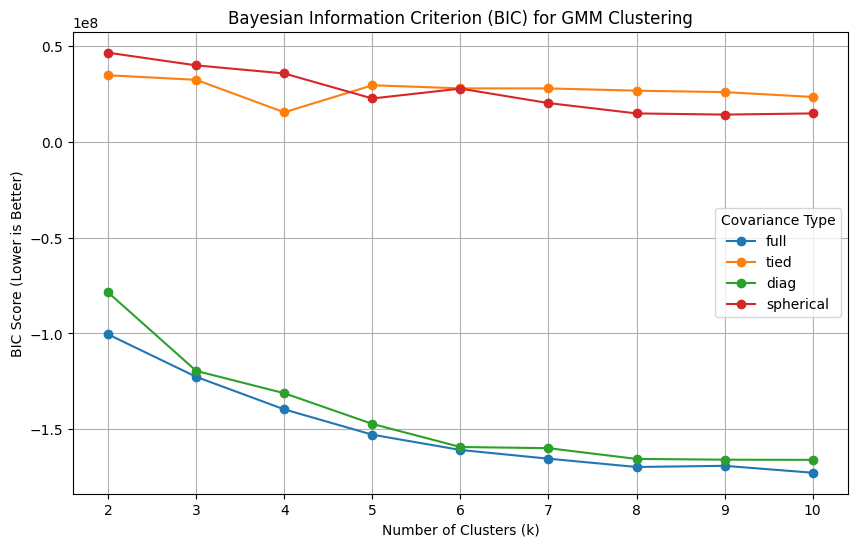

In [ ]:
from sklearn.mixture import GaussianMixture

# Load the Scaled Data (same as the K-Means step)
# BASE_DIR = Path.cwd().parent
BASE_DIR = '..'
try:
    X_scaled_df = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_scaled.csv', index_col='session_id')
    print(f"Loaded scaled feature matrix with shape: {X_scaled_df.shape}")
except FileNotFoundError:
    print("Error: 'session_feature_matrix_scaled.csv' not found.")
    X_scaled_df = None

if X_scaled_df is not None:
    # 1. Define Range and Models
    k_range = range(2, 11) # Test k from 2 to 10
    # Covariance types mimic mclust's model types (e.g., 'E' for equal volume)
    # spherical: 'I', diag: 'D', tied: 'E', full: 'V' (mclust notation)
    # In sklearn: 'spherical', 'diag', 'tied', 'full'
    covariance_types = ['full', 'tied', 'diag', 'spherical']

    # Sample for faster computation, same as silhouette
    n_sample = 20000
    X_sample = X_scaled_df.sample(n=n_sample, random_state=42)
    print(f"Created a random sample of {n_sample} sessions for BIC analysis.")

    bic_scores = []

    print("\nCalculating BIC scores for GMM models...")
    for cov_type in covariance_types:
        for k in k_range:
            try:
                # GMM is fitted with the number of components (k) and the covariance type
                gmm = GaussianMixture(n_components=k, covariance_type=cov_type, random_state=42, n_init=5)
                gmm.fit(X_scaled_df)

                # BIC is a score built into the GMM model
                bic = gmm.bic(X_scaled_df)
                bic_scores.append((k, cov_type, bic))
                print(f"  k={k}, Cov Type='{cov_type}', BIC={bic:.2f}")
            except ValueError as e:
                # Some small k values fail with 'full' or 'tied' on small datasets
                print(f"  Error fitting k={k}, Cov Type='{cov_type}': {e}")
                pass

    # 2. Analyze Results
    bic_df = pd.DataFrame(bic_scores, columns=['k', 'cov_type', 'bic'])

    # Find the model with the minimum BIC score
    best_model = bic_df.loc[bic_df['bic'].idxmin()]
    k_optimal = int(best_model['k'])
    cov_optimal = best_model['cov_type']

    print("\n--- GMM/BIC Optimal Cluster Selection Summary ---")
    print(f"Optimal Number of Clusters (k): {k_optimal}")
    print(f"Optimal Covariance Type: '{cov_optimal}'")
    print(f"Minimum BIC Score: {best_model['bic']:.2f}")

    # 3. Plotting BIC
    plt.figure(figsize=(10, 6))
    for cov_type in covariance_types:
        subset = bic_df[bic_df['cov_type'] == cov_type]
        plt.plot(subset['k'], subset['bic'], marker='o', label=cov_type)

    plt.title('Bayesian Information Criterion (BIC) for GMM Clustering')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('BIC Score (Lower is Better)')
    plt.xticks(list(k_range))
    plt.legend(title='Covariance Type')
    plt.grid(True)
    plt.show()

In [4]:
from sklearn.mixture import GaussianMixture

# found optimal k = 1- and conv_otimal = full to form clusters with a low BIC score of -1945873.70
k_optimal = 10
cov_optimal = 'full'

# 1. Load Data (same as K-Means profiling)
# BASE_DIR = Path.cwd().parent
BASE_DIR = '..'
try:
    X_scaled_df = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_scaled.csv', index_col='session_id')
    print(f"Loaded scaled feature matrix with shape: {X_scaled_df.shape}")
except FileNotFoundError:
    print("Error: 'session_feature_matrix_scaled.csv' not found.")
    X_scaled_df = None

# Assuming 'session_feature_matrix' is in memory or loaded here
# (You may need to load the original session_feature_matrix if it's not in memory)
try:
    # This block requires the original 'session_feature_matrix' DataFrame to be available
    # as defined in the original notebook's feature engineering cell.

    # Placeholder: If the original matrix is not in memory, load it.
    # For a notebook, you might need to save/load it from the feature engineering step.
    # We will assume session_feature_matrix is the original unscaled df.

    features_for_profiling = [
        'session_duration_sec', 'total_events', 'unique_items_viewed',
        'unique_categories_viewed', 'avg_item_availability', 'session_hour_of_day',
        'view_count', 'addtocart_count', 'transaction_count', 'is_buyer',
        'event_rate_per_sec', 'view_to_cart_ratio', 'category_spread_ratio', 'is_weekend'
    ]
    # NOTE: You must ensure 'session_feature_matrix' is defined from the previous cells.
    # If not, you must reload it here.
    X_original_df = pd.read_csv(f'{BASE_DIR}/session_feature_matrix.csv', index_col='session_id')
    X_original_df = session_feature_matrix[features_for_profiling].copy()
    print(f"Loaded original (unscaled) feature matrix for profiling: {X_original_df.shape}")
except Exception as e:
    print(f"Error: Original 'session_feature_matrix' not found in memory. {e}")
    X_original_df = None


if X_scaled_df is not None and X_original_df is not None:

    # 2. Run GMM with Optimal k
    print(f"\nRunning GMM with k={k_optimal} and cov_type='{cov_optimal}' on the full scaled dataset...")

    # Use the optimal parameters from the BIC step
    gmm = GaussianMixture(n_components=k_optimal, covariance_type=cov_optimal, random_state=42, n_init=10)

    # Use .predict() to assign the most likely cluster label to each session
    cluster_labels = gmm.fit_predict(X_scaled_df)

    print("GMM training complete.")

    # 3. Add Labels to Original Data for Profiling
    X_profile = X_original_df.copy()
    X_profile['cluster'] = cluster_labels

    print("Added cluster labels to original (unscaled) data.")

    # 4. Profile the Clusters (Same method as K-Means)
    print("Calculating cluster profiles (mean values)...\n")
    cluster_profiles = X_profile.groupby('cluster').mean()

    # We should also get the size of each cluster
    cluster_size = X_profile['cluster'].value_counts().sort_index()
    cluster_profiles['cluster_size'] = cluster_size
    cluster_profiles['cluster_size_percent'] = (cluster_size / cluster_size.sum()) * 100

    print("--- GMM CLUSTER PROFILES (k=5) ---")

    # Transpose (T) for easier reading in the console
    display(cluster_profiles.T)

    # Save the profiled data for analysis
    X_profile.to_csv(f'{BASE_DIR}/session_feature_matrix_with_gmm_clusters.csv')
    print("\nFull feature matrix with GMM cluster labels saved to 'session_feature_matrix_with_gmm_clusters.csv'")

Loaded scaled feature matrix with shape: (1722864, 12)
Error: Original 'session_feature_matrix' not found in memory. name 'session_feature_matrix' is not defined


## Clusters Visualizations

/tmp/ipython-input-1579699040.py:21: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


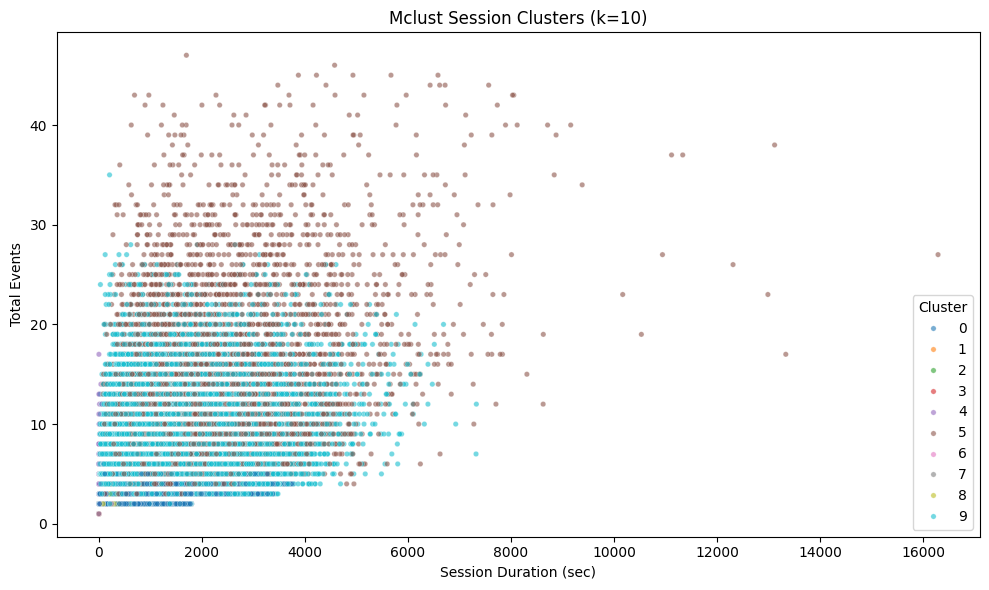

In [ ]:
df = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_with_gmm_clusters.csv', index_col='session_id')

# OPTIONAL: Use a sample for faster plotting if dataset is huge
# df = df.sample(n=5000, random_state=42)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='session_duration_sec',
    y='total_events',
    hue='cluster',
    palette='tab10',  # up to 10 clusters
    alpha=0.6,
    s=15
)

plt.title('Mclust Session Clusters (k=10)')
plt.xlabel('Session Duration (sec)')
plt.ylabel('Total Events')
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

<Axes: xlabel='log_session_duration', ylabel='total_events'>

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


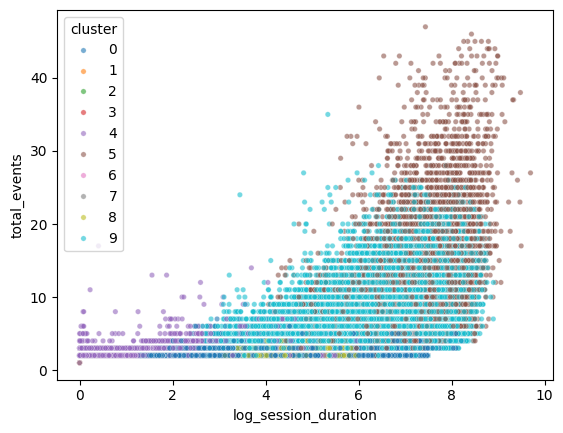

In [ ]:
df['log_session_duration'] = (df['session_duration_sec'] + 1).apply(np.log)
sns.scatterplot(data=df, x='log_session_duration', y='total_events', hue='cluster', palette='tab10', alpha=0.6, s=15)

<Axes: xlabel='log_session_duration', ylabel='unique_items_viewed'>

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


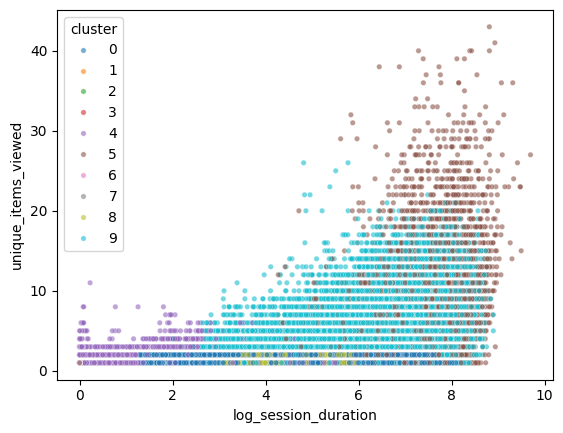

In [ ]:
df['log_session_duration'] = (df['session_duration_sec'] + 1).apply(np.log)
sns.scatterplot(data=df, x='log_session_duration', y='unique_items_viewed', hue='cluster', palette='tab10', alpha=0.6, s=15)

<Axes: xlabel='log_session_duration', ylabel='event_rate_per_sec'>

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


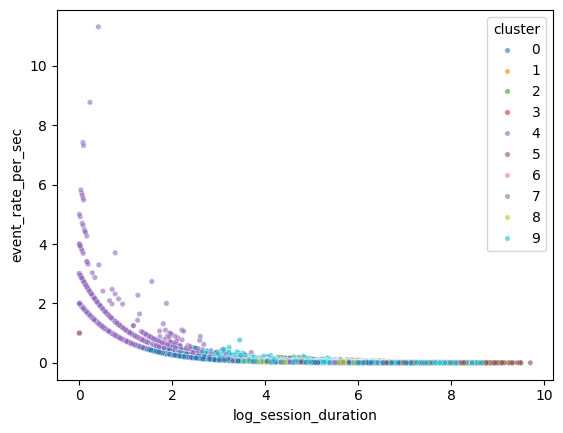

In [ ]:
df['log_session_duration'] = (df['session_duration_sec'] + 1).apply(np.log)
sns.scatterplot(data=df, x='log_session_duration', y='event_rate_per_sec', hue='cluster', palette='tab10', alpha=0.6, s=15)

## Summary / notes

- Cluster 2: "The Out-of-Stock Bouncer" (41.2% of sessions)

  - This is the largest group of users. Their behavior is simple: they have one event (total_events: 1.0), zero duration (session_duration_sec: 0.04), and land on an item that is out of stock (avg_item_availability: 0.0).
  - They bounce immediately. This is a key insight for the e-commerce site.

- Cluster 1: "The In-Stock Bouncer" (27.3% of sessions)

  - This is the second-largest group and nearly identical to Cluster 2. They also have one event (total_events: 1.0) and zero duration (session_duration_sec: 0.01).
  - The only difference is they land on an item that is in stock (avg_item_availability: 1.0). They also bounce.

- Cluster 0: "The Window Shopper" (18.4% of sessions)

  - This is a more engaged browser. They have a medium-long session (session_duration_sec: 351s), but a very low event rate (event_rate_per_sec: 0.035), meaning they are slow and methodical.
  - They look at 2-3 items but have a low view_to_cart_ratio (0.06) and a very low buy rate (is_buyer: 2.8%).

- Cluster 3: "The Uncategorized Bouncer" (11.8% of sessions)

  - This is another "fly-by" group (1.07 events), but their defining feature is that they viewed items with no category (unique_categories_viewed: 0.0). This is a data quality segment.

- Cluster 4: "The Determined Buyer" (1.3% of sessions)

  - This is our most important cluster. It's the smallest group (1.3%) but by far the most valuable.

  - Behavior: They have the longest sessions (1526s, ~25 mins) and the most events (10.8).

  - Intent: They have the highest addtocart_count (0.79) and, critically, the highest view_to_cart_ratio (0.178).

  - Result: They have the highest purchase rate by a huge margin. 9.7% of sessions in this cluster result in a transaction, compared to <3% for all other groups.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# --- Replicating the Paper's Methodology ---
# The paper used the Bayesian Information Criterion (BIC) to find the
# optimal model (k and covariance type). We will do the same.
# We will test a range of cluster counts (k) and all 4 covariance types.

# This assumes 'X_scaled' is your scaled data from the StandardScaler step
# (cell 11 in your notebook).
if 'X_scaled' not in locals():
    print("Error: 'X_scaled' variable not found.")
    print("Please ensure you have run the StandardScaler cell (cell 11) first.")
else:
    # 1. Define your search space
    # We test k=2 through k=10
    n_components_range = range(2, 11)
    # We test all 4 available covariance types
    covariance_types = ['spherical', 'diag', 'tied', 'full']

    # 2. Iterate and find the best BIC
    lowest_bic = np.inf
    best_model = None
    best_n_components = -1
    best_covariance_type = ""

    # Store BIC scores for plotting
    bic_scores = []

    print("Starting GMM model search using BIC...")

    for cov_type in covariance_types:
        for n_components in n_components_range:
            # Fit a Gaussian Mixture Model
            gmm = GaussianMixture(n_components=n_components,
                                  covariance_type=cov_type,
                                  random_state=42,
                                  n_init=10, # Run 10 times and take the best
                                  max_iter=200) # Increase max iterations

            gmm.fit(X_scaled)

            # Calculate the BIC
            bic = gmm.bic(X_scaled)
            bic_scores.append((cov_type, n_components, bic))

            # 3. Select the winner
            if bic < lowest_bic:
                lowest_bic = bic
                best_model = gmm
                best_n_components = n_components
                best_covariance_type = cov_type

    print("---")
    print("Search Complete. Best Model Found:")
    print(f"  Covariance Type: {best_covariance_type}")
    print(f"  Num Clusters (k): {best_n_components}")
    print(f"  Lowest BIC Score: {lowest_bic:.2f}")
    print("---")

    # --- Visualization of BIC Scores (as done in the paper) ---
    print("Plotting BIC scores...")
    df_bic = pd.DataFrame(bic_scores, columns=['covariance_type', 'n_components', 'BIC'])

    plt.figure(figsize=(12, 8))
    sns.lineplot(data=df_bic, x='n_components', y='BIC', hue='covariance_type', marker='o')
    plt.title('GMM Model Selection using BIC')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Bayesian Information Criterion (BIC)')
    plt.xticks(n_components_range)
    plt.legend(title='Covariance Type')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Highlight the best model
    plt.axvline(best_n_components, linestyle='--', color='red', label=f'Best k ({best_n_components})')
    plt.axhline(lowest_bic, linestyle='--', color='red', label=f'Lowest BIC ({lowest_bic:.2f})')
    plt.legend()

    # Save the plot
    bic_plot_path = f'{BASE_DIR}/gmm_bic_selection.png'
    plt.savefig(bic_plot_path)
    print(f"BIC plot saved to {bic_plot_path}")

    # --- Final Step: Use the best model ---
    # This 'best_model' is the one you should use for your analysis
    print(f"\nUsing best model (k={best_n_components}, type='{best_covariance_type}') to predict clusters...")
    cluster_labels_gmm = best_model.predict(X_scaled)

    # Add the labels back to your DataFrame (assuming df_user_features exists)
    if 'df_user_features' in locals():
        df_user_features['cluster_gmm'] = cluster_labels_gmm
        print("Added 'cluster_gmm' column to df_user_features.")
        print(df_user_features['cluster_gmm'].value_counts())
    else:
        print("Warning: 'df_user_features' not found. Could not add cluster labels.")

Starting GMM model search using BIC...


KeyboardInterrupt: 

## Transductive Classification



In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

In [8]:
BASE_DIR = '..'
try:
    session_feature_matrix = pd.read_csv(f'{BASE_DIR}/session_feature_matrix.csv', index_col='session_id')
    print(f"Loaded scaled feature matrix with shape: {session_feature_matrix.shape}")
except FileNotFoundError:
    print("Error: 'session_feature_matrix_scaled.csv' not found.")
    X_scaled_df = None

Loaded scaled feature matrix with shape: (1722864, 16)


In [9]:
display(session_feature_matrix.head())

,session_duration_sec,session_start_time,total_events,unique_items_viewed,unique_categories_viewed,avg_item_availability,session_hour_of_day,session_day_of_week,addtocart_count,transaction_count,view_count,is_buyer,event_rate_per_sec,view_to_cart_ratio,category_spread_ratio,is_weekend
session_id,,,,,,,,,,,,,,,,
0_1,327.736,2015-09-11 20:49:49.439,3,3,3,0.333333,20,4,0,0,3,0,0.009126,0.0,1.000000,0
1000000_1,0.000,2015-06-05 18:16:10.629,1,1,1,0.000000,18,4,0,0,1,0,1.000000,0.0,1.000000,0
1000001_1,0.000,2015-07-07 18:12:14.953,1,1,1,0.000000,18,1,0,0,1,0,1.000000,0.0,1.000000,0
1000001_2,1061.726,2015-07-24 20:18:15.303,3,3,2,1.000000,20,4,0,0,3,0,0.002823,0.0,0.666667,0
1000001_3,0.000,2015-07-29 20:38:29.170,1,1,1,1.000000,20,2,0,0,1,0,1.000000,0.0,1.000000,0


In [11]:


def label_session(row):
    # Out-of-Stock Bouncer
    if row['total_events'] == 1 and row['session_duration_sec'] <= 1 and row['avg_item_availability'] == 0.0:
        return "Out-of-Stock Bouncer"
    # Uncategorized Bouncer
    if row['total_events'] <= 1.1 and row['session_duration_sec'] <= 1 and row['unique_categories_viewed'] == 0:
        return "Uncategorized Bouncer"
    # Determined Buyer
    if (row['session_duration_sec'] > 800 and 
        row['total_events'] > 8 and 
        row['addtocart_count'] > 0 and 
        row['view_to_cart_ratio'] > 0.15 and 
        row['is_buyer'] == 1):
        return "Determined Buyer"
    # Window Shopper
    if (row['session_duration_sec'] >= 100 and row['session_duration_sec'] < 800 and
        2 <= row['unique_items_viewed'] <= 3 and 
        row['event_rate_per_sec'] < 0.04 and
        row['view_to_cart_ratio'] < 0.1):
        return "Window Shopper"
    # Default Fallback
    return "Uncategorized Bouncer"
    
session_feature_matrix['label'] = session_feature_matrix.apply(label_session, axis=1)


In [12]:
display(session_feature_matrix.head())

,session_duration_sec,session_start_time,total_events,unique_items_viewed,unique_categories_viewed,avg_item_availability,session_hour_of_day,session_day_of_week,addtocart_count,transaction_count,view_count,is_buyer,event_rate_per_sec,view_to_cart_ratio,category_spread_ratio,is_weekend,label
session_id,,,,,,,,,,,,,,,,,
0_1,327.736,2015-09-11 20:49:49.439,3,3,3,0.333333,20,4,0,0,3,0,0.009126,0.0,1.000000,0,Window Shopper
1000000_1,0.000,2015-06-05 18:16:10.629,1,1,1,0.000000,18,4,0,0,1,0,1.000000,0.0,1.000000,0,Out-of-Stock Bouncer
1000001_1,0.000,2015-07-07 18:12:14.953,1,1,1,0.000000,18,1,0,0,1,0,1.000000,0.0,1.000000,0,Out-of-Stock Bouncer
1000001_2,1061.726,2015-07-24 20:18:15.303,3,3,2,1.000000,20,4,0,0,3,0,0.002823,0.0,0.666667,0,Uncategorized Bouncer
1000001_3,0.000,2015-07-29 20:38:29.170,1,1,1,1.000000,20,2,0,0,1,0,1.000000,0.0,1.000000,0,Uncategorized Bouncer


In [13]:
# Assume session_feature_matrix is your main features DataFrame (with "is_buyer")
# 1. Choose feature columns used for behavior clustering (from your notebook)
features_for_clustering = [
    'session_duration_sec', 'total_events', 'unique_items_viewed',
    'unique_categories_viewed', 'avg_item_availability',
    'session_hour_of_day', 'view_count', 'addtocart_count',
    'event_rate_per_sec', 'view_to_cart_ratio',
    'category_spread_ratio', 'is_weekend'
]

# 2. Subset (but do not drop "is_buyer" now)
X = session_feature_matrix[features_for_clustering]
# y = session_feature_matrix["is_buyer"]
y = session_feature_matrix["label"]


# 3. Scale X
scaler = StandardScaler()
X_scaled_transductive = scaler.fit_transform(X)

# 4. Convert back to DataFrame and add "is_buyer"
X_scaled_df_transductive = pd.DataFrame(X_scaled_transductive, columns=features_for_clustering, index=session_feature_matrix.index)
# X_scaled_df_transductive["is_buyer"] = y.values
X_scaled_df_transductive["label"] = y.values



In [16]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading


# 1. Stratified sampling to get 200,000 rows, preserving class ratio
sample_size = 20_000
#stratify_col = X_scaled_df_transductive['is_buyer']
stratify_col = X_scaled_df_transductive['label']

sample_df, _ = train_test_split(
    X_scaled_df_transductive,
    train_size=sample_size,
    stratify=stratify_col,
    shuffle=True,
    random_state=42
)
# Encode string labels → integer classes
le = LabelEncoder()
encoded_labels = le.fit_transform(sample_df["label"])

X = sample_df.drop("label", axis=1).values
y = encoded_labels   # now numeric

# 3. Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Mask 90% of labels
rng = np.random.RandomState(42)
labeled_mask = rng.rand(len(y_train)) < 0.1

labels = np.full(len(y_train), -1, dtype=int)
labels[labeled_mask] = y_train[labeled_mask]

# 5. Fit LabelSpreading
label_spread = LabelSpreading(kernel='rbf', gamma=0.25)
label_spread.fit(X_train, labels)

# 6. Predictions
y_pred_train = label_spread.predict(X_train)
y_pred_test = label_spread.predict(X_test)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import LabelSpreading

# 1. Stratified sampling to get 200,000 rows, preserving class ratio
sample_size = 20_000
#stratify_col = X_scaled_df_transductive['is_buyer']
stratify_col = X_scaled_df_transductive['label']

sample_df, _ = train_test_split(
    X_scaled_df_transductive,
    train_size=sample_size,
    stratify=stratify_col,
    shuffle=True,
    random_state=42
)

# 2. Continue as before but use sample_df
X = sample_df.drop("is_buyer", axis=1).values
y = sample_df["is_buyer"].values

# # 2. Continue as before but use sample_df
# X = sample_df.drop("label", axis=1).values
# y = sample_df["label"].values

# 3. Stratified 80/20 split for model dev/evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 4. Mask most labels in training for transductive/semi-supervised learning
rng = np.random.RandomState(42)
labeled_mask = rng.rand(len(y_train)) < 0.1
labels = np.full_like(y_train, -1)
labels[labeled_mask] = y_train[labeled_mask]

# 5. Fit LabelSpreading on training data only
from sklearn.semi_supervised import LabelSpreading

label_spread = LabelSpreading(kernel='rbf', gamma=0.25)
label_spread.fit(X_train, labels)

# 6. Predict for both train and test sets
y_pred_train = label_spread.predict(X_train)
y_pred_test = label_spread.predict(X_test)

# 7. (Optional) Add predictions to DataFrame for analysis
feature_cols = sample_df.drop("is_buyer", axis=1).columns
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["is_buyer_true"] = y_train
train_df["is_buyer_pred"] = y_pred_train

test_df = pd.DataFrame(X_test, columns=feature_cols)
test_df["is_buyer_true"] = y_test
test_df["is_buyer_pred"] = y_pred_test

# 7. (Optional) Add predictions to DataFrame for analysis
# feature_cols = sample_df.drop("label", axis=1).columns
# train_df = pd.DataFrame(X_train, columns=feature_cols)
# train_df["label_true"] = y_train
# train_df["label_predict"] = y_pred_train

# test_df = pd.DataFrame(X_test, columns=feature_cols)
# test_df["label_true"] = y_test
# test_df["label_predict"] = y_pred_test

ValueError: Unknown label type: unknown. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

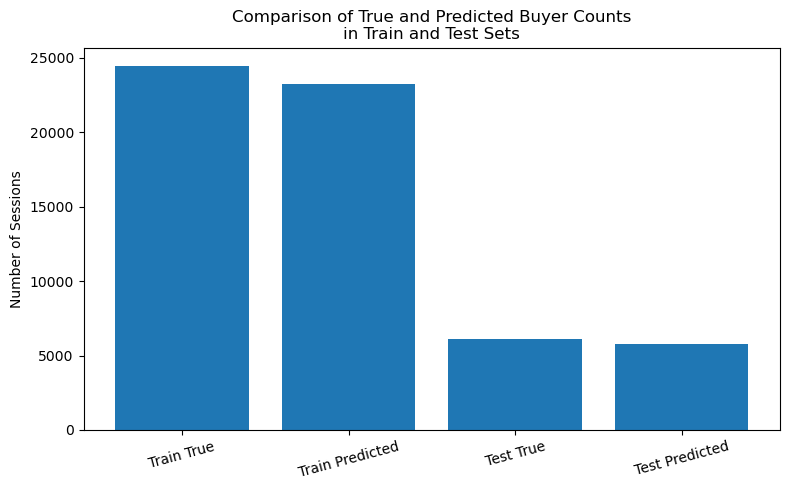

In [17]:
feature_cols = sample_df.drop("label", axis=1).columns

# TRAIN DF
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["label_true"] = y_train
train_df["label_pred"] = y_pred_train

# TEST DF
test_df = pd.DataFrame(X_test, columns=feature_cols)
test_df["label_true"] = y_test
test_df["label_pred"] = y_pred_test

import matplotlib.pyplot as plt

labels = ['Train True', 'Train Predicted', 'Test True', 'Test Predicted']
buyer_counts = [
    train_df['label_true'].sum(),
    train_df['label_pred'].sum(),
    test_df['label_true'].sum(),
    test_df['label_pred'].sum(),
]

plt.figure(figsize=(8,5))
plt.bar(labels, buyer_counts)
plt.title('Comparison of True and Predicted Buyer Counts\nin Train and Test Sets')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


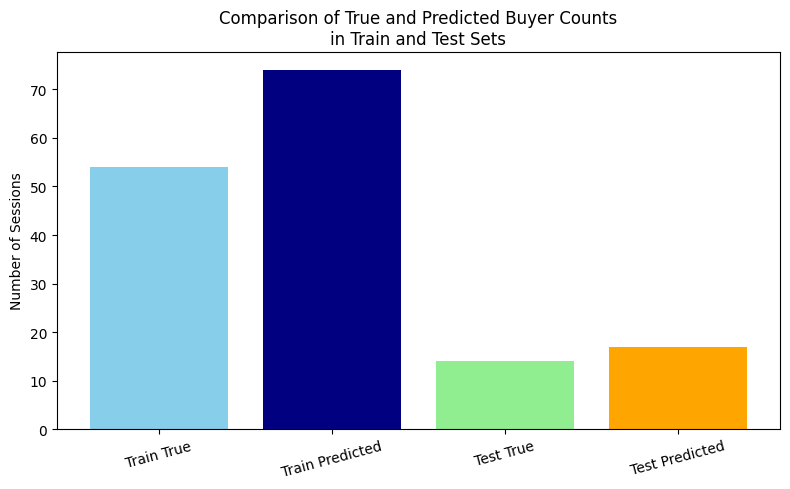

In [ ]:
import matplotlib.pyplot as plt

# Bar chart comparing number of buyers (true and predicted) in train and test sets
labels = ['Train True', 'Train Predicted', 'Test True', 'Test Predicted']
buyer_counts = [
    train_df['is_buyer_true'].sum(),
    train_df['is_buyer_pred'].sum(),
    test_df['is_buyer_true'].sum(),
    test_df['is_buyer_pred'].sum(),
]

colors = ['skyblue', 'navy', 'lightgreen', 'orange']
plt.figure(figsize=(8,5))
plt.bar(labels, buyer_counts, color=colors)
plt.title('Comparison of True and Predicted Buyer Counts\nin Train and Test Sets')
plt.ylabel('Number of Sessions')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

Accuracy:  0.9225
Precision: 0.4601 (macro)
Recall:    0.4831 (macro)
F1-score:  0.4713 (macro)
ROC AUC:   N/A for multiclass without probability scores


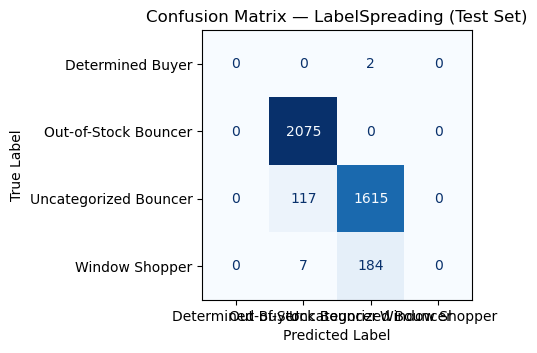

In [21]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt

# Extract true & predicted labels
y_true = test_df['label_true']
y_pred = test_df['label_pred']

# MULTICLASS-SAFE METRICS
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

# Print metrics
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f} (macro)")
print(f"Recall:    {recall:.4f} (macro)")
print(f"F1-score:  {f1:.4f} (macro)")
print("ROC AUC:   N/A for multiclass without probability scores")

# CONFUSION MATRIX
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(5,5))

# Display ORIGINAL STRING LABELS
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_   # <── THIS SHOWS THE ORIGINAL STRINGS
)

disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix — LabelSpreading (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Accuracy:      0.9925
Precision:     0.4444
Recall:        0.4444
F1-score:      0.4444
ROC AUC:       0.7203344799619655


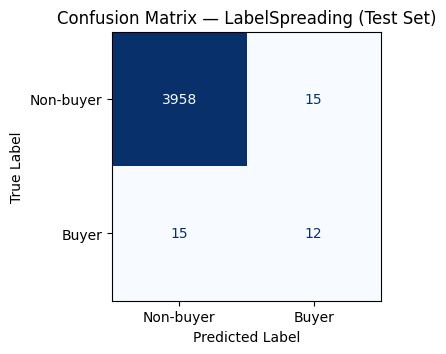

In [ ]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)
import matplotlib.pyplot as plt

# Calculate metrics
acc = accuracy_score(test_df['is_buyer_true'], test_df['is_buyer_pred'])
precision = precision_score(test_df['is_buyer_true'], test_df['is_buyer_pred'], zero_division=0)
recall = recall_score(test_df['is_buyer_true'], test_df['is_buyer_pred'], zero_division=0)
f1 = f1_score(test_df['is_buyer_true'], test_df['is_buyer_pred'], zero_division=0)
# For ROC AUC, need probabilities. If unavailable, skip or use .decision_function/.predict_proba if possible.
try:
    auc = roc_auc_score(test_df['is_buyer_true'], test_df['is_buyer_pred'])
except:
    auc = "N/A (needs probability output)"

# Print metrics
print(f"Accuracy:      {acc:.4f}")
print(f"Precision:     {precision:.4f}")
print(f"Recall:        {recall:.4f}")
print(f"F1-score:      {f1:.4f}")
print(f"ROC AUC:       {auc}")

# Confusion matrix
cm = confusion_matrix(test_df['is_buyer_true'], test_df['is_buyer_pred'])
fig, ax = plt.subplots(figsize=(4,4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-buyer", "Buyer"])
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix — LabelSpreading (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# Market Basket

In [ ]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import warnings

warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    message=r".*utcnow\(\) is deprecated.*"
)

In [ ]:
# Assume BASE_DIR is in memory from your notebook
BASE_DIR = '/content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project'

try:
    # 1. Load the cluster assignments
    df_clusters = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_with_clusters.csv', index_col='session_id')
    print(f"Successfully loaded {len(df_clusters)} sessions with cluster labels.")

    # 2. Load the raw events log
    df_events_raw = pd.read_csv(f'{BASE_DIR}/dataset/events.csv')
    print(f"Successfully loaded {len(df_events_raw)} raw events.")

    # 3. Load the category baskets
    with open(f'{BASE_DIR}/category_baskets.csv', 'r') as f:
        all_baskets_list = [list(map(int, line.strip().split(','))) for line in f]

    # We also need the transactionid index from that file for mapping
    basket_index_df = pd.read_csv(f'{BASE_DIR}/category_baskets.csv', header=None, usecols=[0], names=['transactionid'])

    # --- THIS IS THE FIX ---
    # REASONING: We explicitly create a DataFrame with one column named 'basket'
    # and assign the list of lists (all_baskets_list) to that single column.
    basket_map = pd.DataFrame({'basket': all_baskets_list}, index=basket_index_df['transactionid'])

    print(f"Successfully loaded {len(basket_map)} total market baskets.")

except FileNotFoundError as e:
    print(f"Error: A required file was not found. {e}")
    print("Please ensure 'session_feature_matrix_with_clusters.csv', 'events.csv', and 'category_baskets.csv' are in the same directory.")

Successfully loaded 1722864 sessions with cluster labels.
Successfully loaded 2756101 raw events.
Successfully loaded 12185 total market baskets.


In [ ]:
# 1. Re-run identical cleaning steps from Milestone 1
print("Re-running cleaning and sessionization to create session-transaction map...")

# Fill expected NaNs
df_events_raw['transactionid'] = df_events_raw['transactionid'].fillna(0).astype(int)

# 2. Re-run identical noise handling from Milestone 1
events_per_visitor = df_events_raw.groupby('visitorid')['event'].count()
outlier_threshold = events_per_visitor.quantile(0.999)
outlier_visitors = events_per_visitor[events_per_visitor > outlier_threshold].index
df_events_cleaned = df_events_raw[~df_events_raw['visitorid'].isin(outlier_visitors)].copy()

# 3. Re-run identical sessionization from Milestone 1
df_events_cleaned['timestamp_dt'] = pd.to_datetime(df_events_cleaned['timestamp'], unit='ms')
df_events_cleaned.sort_values(by=['visitorid', 'timestamp_dt'], inplace=True)
session_timeout_seconds = 30 * 60
df_events_cleaned['time_diff_seconds'] = df_events_cleaned.groupby('visitorid')['timestamp_dt'].diff().dt.total_seconds()
df_events_cleaned['new_session_flag'] = (df_events_cleaned['time_diff_seconds'] > session_timeout_seconds) | (df_events_cleaned['time_diff_seconds'].isnull())
df_events_cleaned['session_increment_id'] = df_events_cleaned.groupby('visitorid')['new_session_flag'].cumsum()
df_events_cleaned['session_id'] = df_events_cleaned['visitorid'].astype(str) + '_' + df_events_cleaned['session_increment_id'].astype(str)

# 4. Create the final map
# We only need session_id and transactionid, and we only care about actual transactions
session_to_transaction_map = df_events_cleaned[
    df_events_cleaned['transactionid'] != 0
][['session_id', 'transactionid']].drop_duplicates()

print(f"Successfully created mapping for {len(session_to_transaction_map)} session-transaction pairs.")
print(session_to_transaction_map.head())

Re-running cleaning and sessionization to create session-transaction map...
Successfully created mapping for 12191 session-transaction pairs.
        session_id  transactionid
848114       172_4           9725
814996       186_1           8726
1276395      264_1           8445
2687635      419_3          16455
273133       539_1          14778


In [ ]:
# 1. Identify our target cluster's session IDs
CLUSTER_ID = 4 # This is our "Determined Buyer" cluster
buyer_session_ids = df_clusters[df_clusters['cluster'] == CLUSTER_ID].index
print(f"Identified {len(buyer_session_ids):,} sessions in Cluster {CLUSTER_ID}.")

# 2. Find the transaction IDs for this cluster
target_transactions = session_to_transaction_map[
    session_to_transaction_map['session_id'].isin(buyer_session_ids)
]
target_transaction_ids = target_transactions['transactionid'].unique()
print(f"Found {len(target_transaction_ids):,} unique transaction IDs for Cluster {CLUSTER_ID}.")

# 3. Filter the main basket_map
cluster_baskets_df = basket_map[basket_map.index.isin(target_transaction_ids)]
cluster_baskets_list = cluster_baskets_df['basket'].tolist()

print(f"Successfully filtered to {len(cluster_baskets_list)} market baskets for Apriori.")

Identified 22,784 sessions in Cluster 4.
Found 2,461 unique transaction IDs for Cluster 4.
Successfully filtered to 1913 market baskets for Apriori.


## Assosication Rule Mining

In [ ]:
print("# Mining Cluster 4 ('Determined Buyer') Rules ---")

# 1. One-hot encode the transaction data
te = TransactionEncoder()
te_ary = te.fit(cluster_baskets_list).transform(cluster_baskets_list)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# 2. Run Apriori to find frequent itemsets
# We use a higher min_support (0.5%) because this is a larger, sparse group.
frequent_itemsets_cluster = apriori(df_onehot, min_support=0.005, use_colnames=True)
print(f"Found {len(frequent_itemsets_cluster)} frequent itemsets in Cluster 4.")
display(frequent_itemsets_cluster.head())

# 3. Generate association rules
# We filter for a high lift (>= 1.5) to find strong, non-random patterns.
cluster_rules = association_rules(frequent_itemsets_cluster, metric="lift", min_threshold=1.5)
cluster_rules = cluster_rules.sort_values(by='lift', ascending=False)

print(f"Generated {len(cluster_rules)} rules with lift >= 1.5.")

# 4. Display and save results
print("\n# Top 10 Rules for 'Determined Buyers' (by Lift)")
display(cluster_rules.head(10))
cluster_rules.to_csv(f'{BASE_DIR}/cluster_4_rules.csv', index=False)
print("\nSaved Cluster 4 rules to '{BASE_DIR}/cluster_4_rules.csv'")

# Mining Cluster 4 ('Determined Buyer') Rules ---
Found 50 frequent itemsets in Cluster 4.


,support,itemsets
0,0.014114,(120)
1,0.031887,(191)
2,0.011500,(230)
3,0.005750,(299)
4,0.005227,(316)


Generated 4 rules with lift >= 1.5.

# Top 10 Rules for 'Determined Buyers' (by Lift)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(618),(1421),0.064820,0.006273,0.005227,0.080645,12.856183,1.0,0.004821,1.080896,0.986138,0.079365,0.074842,0.456989
1,(1421),(618),0.006273,0.064820,0.005227,0.833333,12.856183,1.0,0.004821,5.611082,0.928038,0.079365,0.821781,0.456989
2,(1037),(1286),0.069002,0.008887,0.006796,0.098485,11.082442,1.0,0.006182,1.099386,0.977195,0.095588,0.090402,0.431595
3,(1286),(1037),0.008887,0.069002,0.006796,0.764706,11.082442,1.0,0.006182,3.956743,0.917924,0.095588,0.747267,0.431595



Saved Cluster 4 rules to '{BASE_DIR}/cluster_4_rules.csv'


In [ ]:
print("# Mining Cluster 4 ('Determined Buyer') Rules ---")

# 1. One-hot encode the transaction data
te = TransactionEncoder()
te_ary = te.fit(cluster_baskets_list).transform(cluster_baskets_list)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# 2. Run Apriori to find frequent itemsets
# We use a higher min_support (0.5%) because this is a larger, sparse group.
frequent_itemsets_cluster = apriori(df_onehot, min_support=0.005, use_colnames=True)
print(f"Found {len(frequent_itemsets_cluster)} frequent itemsets in Cluster 4.")
display(frequent_itemsets_cluster.head())

# 3. Generate association rules
# We filter for a high lift (>= 1.5) to find strong, non-random patterns.
cluster_rules = association_rules(frequent_itemsets_cluster, metric="lift", min_threshold=1.5)
cluster_rules = cluster_rules.sort_values(by='lift', ascending=False)

print(f"Generated {len(cluster_rules)} rules with lift >= 1.5.")

# 4. Display and save results
print("\n# Top 10 Rules for 'Determined Buyers' (by Lift)")
display(cluster_rules.head(10))
cluster_rules.to_csv(f'{BASE_DIR}/cluster_4_rules.csv', index=False)
print("\nSaved Cluster 4 rules to '{BASE_DIR}/cluster_4_rules.csv'")

In [ ]:
# 1. Re-run identical cleaning steps from Milestone 1
print("Re-running cleaning and sessionization to create session-transaction map...")

# Fill expected NaNs
df_events_raw['transactionid'] = df_events_raw['transactionid'].fillna(0).astype(int)

# 2. Re-run identical noise handling from Milestone 1
events_per_visitor = df_events_raw.groupby('visitorid')['event'].count()
outlier_threshold = events_per_visitor.quantile(0.999)
outlier_visitors = events_per_visitor[events_per_visitor > outlier_threshold].index
df_events_cleaned = df_events_raw[~df_events_raw['visitorid'].isin(outlier_visitors)].copy()

# 3. Re-run identical sessionization from Milestone 1
df_events_cleaned['timestamp_dt'] = pd.to_datetime(df_events_cleaned['timestamp'], unit='ms')
df_events_cleaned.sort_values(by=['visitorid', 'timestamp_dt'], inplace=True)
session_timeout_seconds = 30 * 60
df_events_cleaned['time_diff_seconds'] = df_events_cleaned.groupby('visitorid')['timestamp_dt'].diff().dt.total_seconds()
df_events_cleaned['new_session_flag'] = (df_events_cleaned['time_diff_seconds'] > session_timeout_seconds) | (df_events_cleaned['time_diff_seconds'].isnull())
df_events_cleaned['session_increment_id'] = df_events_cleaned.groupby('visitorid')['new_session_flag'].cumsum()
df_events_cleaned['session_id'] = df_events_cleaned['visitorid'].astype(str) + '_' + df_events_cleaned['session_increment_id'].astype(str)

# 4. Create the final map
# We only need session_id and transactionid, and we only care about actual transactions
session_to_transaction_map = df_events_cleaned[
    df_events_cleaned['transactionid'] != 0
][['session_id', 'transactionid']].drop_duplicates()

print(f"Successfully created mapping for {len(session_to_transaction_map)} session-transaction pairs.")
print(session_to_transaction_map.head())

Re-running cleaning and sessionization to create session-transaction map...
Successfully created mapping for 12191 session-transaction pairs.
        session_id  transactionid
848114       172_4           9725
814996       186_1           8726
1276395      264_1           8445
2687635      419_3          16455
273133       539_1          14778


In [ ]:
# Assume BASE_DIR is in memory from your notebook
BASE_DIR = '/content/drive/MyDrive/UP Honours/COS781 -Data Mining/Project'

try:
    # 1. Load the cluster assignments
    df_clusters = pd.read_csv(f'{BASE_DIR}/session_feature_matrix_with_gmm_clusters.csv', index_col='session_id')
    print(f"Successfully loaded {len(df_clusters)} sessions with cluster labels.")

    # 2. Load the raw events log
    df_events_raw = pd.read_csv(f'{BASE_DIR}/dataset/events.csv')
    print(f"Successfully loaded {len(df_events_raw)} raw events.")

    # 3. Load the category baskets
    with open(f'{BASE_DIR}/category_baskets.csv', 'r') as f:
        all_baskets_list = [list(map(int, line.strip().split(','))) for line in f]

    # We also need the transactionid index from that file for mapping
    basket_index_df = pd.read_csv(f'{BASE_DIR}/category_baskets.csv', header=None, usecols=[0], names=['transactionid'])

    # --- THIS IS THE FIX ---
    # REASONING: We explicitly create a DataFrame with one column named 'basket'
    # and assign the list of lists (all_baskets_list) to that single column.
    basket_map = pd.DataFrame({'basket': all_baskets_list}, index=basket_index_df['transactionid'])

    print(f"Successfully loaded {len(basket_map)} total market baskets.")

except FileNotFoundError as e:
    print(f"Error: A required file was not found. {e}")
    print("Please ensure 'session_feature_matrix_with_gmm_clusters.csv', 'events.csv', and 'category_baskets.csv' are in the same directory.")

Successfully loaded 1722864 sessions with cluster labels.
Successfully loaded 2756101 raw events.
Successfully loaded 12185 total market baskets.


In [ ]:
# 1. Identify our target cluster's session IDs
CLUSTER_ID = 5 # This is our "Determined Buyer" cluster
buyer_session_ids = df_clusters[df_clusters['cluster'] == CLUSTER_ID].index
print(f"Identified {len(buyer_session_ids):,} sessions in Cluster {CLUSTER_ID}.")

# 2. Find the transaction IDs for this cluster
target_transactions = session_to_transaction_map[
    session_to_transaction_map['session_id'].isin(buyer_session_ids)
]
target_transaction_ids = target_transactions['transactionid'].unique()
print(f"Found {len(target_transaction_ids):,} unique transaction IDs for Cluster {CLUSTER_ID}.")

# 3. Filter the main basket_map
cluster_baskets_df = basket_map[basket_map.index.isin(target_transaction_ids)]
cluster_baskets_list = cluster_baskets_df['basket'].tolist()

print(f"Successfully filtered to {len(cluster_baskets_list)} market baskets for Apriori.")

Identified 21,424 sessions in Cluster 5.
Found 8,297 unique transaction IDs for Cluster 5.
Successfully filtered to 4890 market baskets for Apriori.


In [ ]:

# 1. One-hot encode the transaction data
te = TransactionEncoder()
te_ary = te.fit(cluster_baskets_list).transform(cluster_baskets_list)
df_onehot = pd.DataFrame(te_ary, columns=te.columns_)

# 2. Run Apriori to find frequent itemsets
# We use a higher min_support (0.5%) because this is a larger, sparse group.
frequent_itemsets_cluster = apriori(df_onehot, min_support=0.005, use_colnames=True)
print(f"Found {len(frequent_itemsets_cluster)} frequent itemsets in Cluster 4.")
display(frequent_itemsets_cluster.head())

# 3. Generate association rules
# We filter for a high lift (>= 1.5) to find strong, non-random patterns.
cluster_rules = association_rules(frequent_itemsets_cluster, metric="lift", min_threshold=1.5)
cluster_rules = cluster_rules.sort_values(by='lift', ascending=False)

print(f"Generated {len(cluster_rules)} rules with lift >= 1.5.")

# 4. Display and save results
print("\n# Top 10 Rules for 'Determined Buyers' (by Lift)")
display(cluster_rules.head(10))
cluster_rules.to_csv(f'{BASE_DIR}/cluster_3_GMM_rules.csv', index=False)
print("\nSaved Cluster 4 rules to '{BASE_DIR}/cluster_3_GMM_rules.csv.csv'")

Found 66 frequent itemsets in Cluster 4.


,support,itemsets
0,0.020450,(48)
1,0.005317,(56)
2,0.005521,(120)
3,0.006135,(124)
4,0.012270,(175)


Generated 2 rules with lift >= 1.5.

# Top 10 Rules for 'Determined Buyers' (by Lift)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1,(1421),(618),0.030675,0.031288,0.007771,0.253333,8.096732,1.0,0.006811,1.297382,0.904231,0.143396,0.229217,0.25085
0,(618),(1421),0.031288,0.030675,0.007771,0.248366,8.096732,1.0,0.006811,1.289624,0.904803,0.143396,0.224580,0.25085



Saved Cluster 4 rules to '{BASE_DIR}/cluster_3_GMM_rules.csv.csv'


### Some notes for the Association Rule Mining:

Market Basket Filtering
Reason (Why): Our project requires us to find the unique patterns within our "Determined Buyer" cluster (Cluster 4), not the patterns of all buyers. We must first isolate the transactions from this specific cluster.

How (Implementation):

Load the session_feature_matrix_with_clusters.csv file you just created.

Identify all session_ids that belong to Cluster 4.

Load df_events (from COS781_Data_Cleaning_+_Features.ipynb, Cell 11) and find all transactionids associated with those Cluster 4 session_ids.

Load our full market basket files (item_baskets.csv and category_baskets.csv).

Filter these files to create two new lists: cluster_4_item_baskets and cluster_4_category_baskets, containing only the transactions from our target cluster.

Result (What we have): A clean, filtered list of market baskets (both item-level and category-level) that represent only the purchasing behavior of the "Determined Buyer" segment.

###  (Recommended) Category-Level Market Basket Analysis
Reason (Why): The user requested this. Mining by itemid can be too specific (sparse). Mining by categoryid provides more general and interpretable rules (e.g., "users who buy Electronics also buy Batteries").

How (Implementation): We will use the cluster_4_category_baskets list (created in the step above) as the primary input for the Apriori algorithm.

Result (What we have): High-level, interpretable rules based on product categories.

### Section Title: Association Rule Mining (Apriori)
Reason (Why): To discover the high-strength, statistically significant purchasing patterns that define our "Determined Buyer" cluster.

How (Implementation):

Use mlxtend.preprocessing.TransactionEncoder to one-hot encode our cluster_4_category_baskets list.

Use mlxtend.frequent_patterns.apriori on the one-hot encoded DataFrame to find frequent itemsets (categories).

Use mlxtend.frequent_patterns.association_rules to generate the final rules.

Sort the resulting rules by Lift (our key success metric) in descending order.


Result (What we have): A DataFrame of "Cluster-Specific Rules" (e.g., {Category A} -> {Category B}) ranked by Support, Confidence, and Lift.

### Section Title: Baseline Model Generation

Reason (Why): Our project's success is measured by comparing our cluster-specific rules against a baseline. We need to prove our 2-stage methodology provides better (higher-Lift) rules than a simple, one-stage analysis.


How (Implementation): Repeat Step 3 (Apriori), but this time use the full, unfiltered category_baskets.csv file (all 17,672 baskets).

Result (What we have): A "Baseline Rules" DataFrame, also with Support, Confidence, and Lift.